In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')s

Mounted at /content/drive


In [ ]:
!pip install pyro-ppl
!pip install pot
!pip install tensorboard
!pip install torchdiffeq
!pip install openml

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
!rm -rf PFNExperiments
!git clone https://github.com/ArikReuter/PFNExperiments


Cloning into 'PFNExperiments'...
remote: Enumerating objects: 1513, done.
remote: Counting objects: 100% (286/286), done.
remote: Compressing objects: 100% (192/192), done.
remote: Total 1513 (delta 196), reused 174 (delta 92), pack-reused 1227 (from 1)
Receiving objects: 100% (1513/1513), 60.48 MiB | 15.96 MiB/s, done.
Resolving deltas: 100% (1080/1080), done.


In [ ]:
import torch
from PFNExperiments.LinearRegression.GenerativeModels.GenerateData import GenerateData, check_data, check_and_plot_data
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataLM_ExamplesIntercept import make_lm_program_ig_intercept, make_lm_program_ig_intercept_batched

from PFNExperiments.LinearRegression.GenerativeModels.GenerateX import simulate_X_uniform
from PFNExperiments.LinearRegression.GenerativeModels.LM_abstract import return_only_y, print_code
from PFNExperiments.LinearRegression.GenerativeModels.Quantizer import Quantizer
from PFNExperiments.LinearRegression.Models.Transformer_CNF import TransformerCNFConditionalDecoder
from PFNExperiments.Training.Trainer import Trainer, batch_to_model_lm, visualize_training_results
from PFNExperiments.Training.Losses import MSELoss_unsqueezed, nll_loss_full_gaussian
from PFNExperiments.Training.EvalMetrics import mean_squared_error_torch_avg, mae_torch_avg, r2_score_torch_avg
from PFNExperiments.LinearRegression.Models.ModelPosterior import ModelPosteriorFullGaussian, ModelPosteriorFullGaussian2
from PFNExperiments.LinearRegression.Models.AugmentLoss import add_l2_loss_nll_loss
from PFNExperiments.LinearRegression.Models.ModelToPosteriorCNF_LearnedBaseDist import ModelToPosteriorCNF_LearnedBaseDist

from PFNExperiments.Training.FlowMatching.CFMLossOT2 import CFMLossOT2

from PFNExperiments.Evaluation.ComparePosteriorSamples import compare_all_metrics, marginal_plots_hist_parallel, marginal_plots_kde_together
from PFNExperiments.LinearRegression.Evaluation.CompareModels import ModelComparison
from PFNExperiments.LinearRegression.Models.ModelToPosteriorCNF import ModelToPosteriorCNF
from PFNExperiments.LinearRegression.ComparisonModels.Hamiltionion_MC import Hamiltionian_MC

from PFNExperiments.LinearRegression.ComparisonModels.Variational_Inference import Variational_Inference, make_guide_program_gamma_gamma

from PFNExperiments.LinearRegression.Evaluation.CompareComparisonModels import CompareComparisonModels

from PFNExperiments.LinearRegression.GenerativeModels.Curriculum import Curriculum
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataCurriculumCFM import GenerateDataCurriculumCFM

from PFNExperiments.Training.TrainerCurriculumCNF import TrainerCurriculumCNF

from PFNExperiments.LinearRegression.ComparisonModels.AnalyticalSolutionsLM import PosteriorLM_IG
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataLM_Examples import make_lm_program_ig_batched, make_lm_program_ig
from PFNExperiments.LinearRegression.GenerativeModels.GenerateX import simulate_X_uniform

from PFNExperiments.LinearRegression.Evaluation.CompareComparisonModels import CompareComparisonModels

from PFNExperiments.Training.FlowMatching.Couplings import MiniBatchOTCoupling

from PFNExperiments.LinearRegression.ComparisonModels.Variational_InferenceAutoguide import Variational_InferenceAutoguide

from pyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoLaplaceApproximation, AutoIAFNormal, AutoStructured
from PFNExperiments.Evaluation.Evaluate import Evaluate

from PFNExperiments.Evaluation.RealWorldEvaluation.PreprocessDataset import Preprocessor
from PFNExperiments.Evaluation.RealWorldEvaluation.GetDataOpenML import GetDataOpenML

from PFNExperiments.Evaluation.RealWorldEvaluation.EvaluateRealWorld import EvaluateRealWorld
from PFNExperiments.Evaluation.RealWorldEvaluation.EvaluateRealWorld import just_return_results, results_dict_to_latent_variable_beta0_and_beta

In [ ]:
torch.backends.cudnn.benchmark = True

In [ ]:
N = 50
P = 5
BATCH_SIZE = 1024
N_EPOCHS = 100
N_SAMPLES_PER_EPOCH = 500_000
N_BATCHES_PER_EPOCH = N_SAMPLES_PER_EPOCH//BATCH_SIZE
SAVE_PATH = "/content/drive/MyDrive/PFN_Experiments/Training_RunsCFM"
SAVE_PATH_EVALUATION = f"{SAVE_PATH}/PFN_Experiments_CFM_InverseGamma_intercept_v2_EvaluateRealWorld_v3"

#BATCH_SIZE = 128

In [ ]:
a = 5.0
b = 2.0
tau = 1.0
tau_beta0 = 3.0

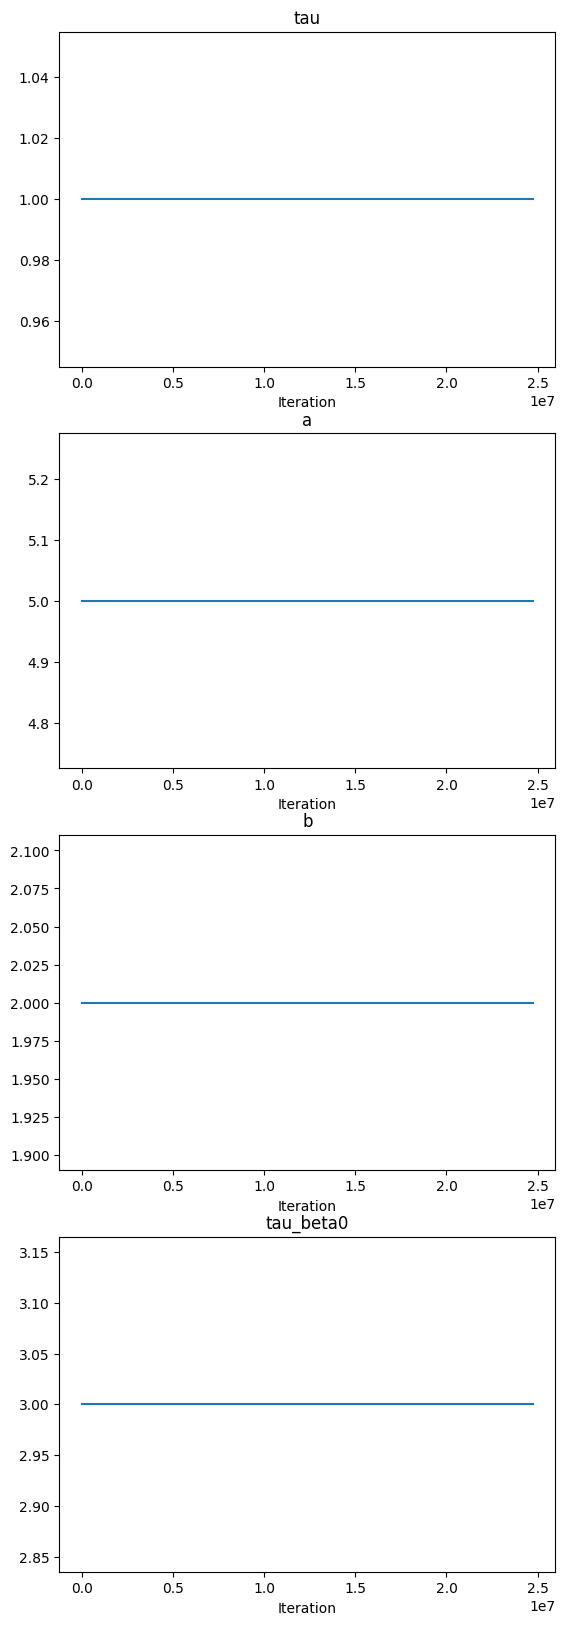

In [ ]:
curriculum = Curriculum(max_iter=int(N_EPOCHS*N_BATCHES_PER_EPOCH*BATCH_SIZE*0.5))
curriculum.add_param_list(
    [
    ("tau", curriculum.constant_scheduler(tau)),
    ("a", curriculum.constant_scheduler(a)),
    ("b", curriculum.constant_scheduler(b)),
    ("tau_beta0", curriculum.constant_scheduler(tau_beta0)),

    ]
)
curriculum.plot_all_schedules()

In [ ]:
curriculum.get_params(299*N_SAMPLES_PER_EPOCH)

{'tau': 1.0, 'a': 5.0, 'b': 2.0, 'tau_beta0': 3.0}

In [ ]:
data_generator = GenerateDataCurriculumCFM(
    pprogram_maker= make_lm_program_ig_intercept_batched,
    curriculum= curriculum,
    #coupling = None
)

pprogram_covariates_train is None, using pprogram_covariates instead
pprogram_covariates_val is None, using pprogram_covariates instead
pprogram_covariates_test is None, using pprogram_covariates instead


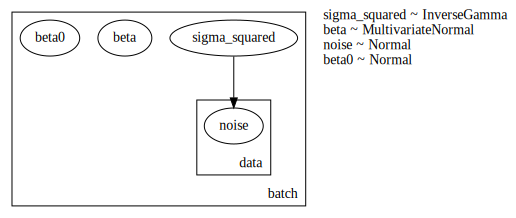

In [ ]:
data_generator.render_model()

In [ ]:
epoch_loader = data_generator.make_epoch_loader(
    n = N,
    p = P,
    number_of_batches_per_epoch = N_BATCHES_PER_EPOCH,
    n_epochs = N_EPOCHS,
    batch_size= BATCH_SIZE,
    train_frac= 0.5,
    val_frac= 0.1,
    shuffle=False,
    n_samples_to_generate_at_once = 250_000
)

The number of batches times the number of epochs must be equal to the total number of iterations in the curriculum. But got 49971200 and 24985600 respectively


In [ ]:
#save_path_model = "/content/drive/MyDrive/PFN_Experiments/Training_Runs/experiment_2024_05_29_07_37_35/model.pth"

In [ ]:

model = TransformerCNFConditionalDecoder(
    n_input_features_encoder = P+1,
    n_input_features_decoder = P+1,
    d_model_encoder = 512,
    d_model_decoder = 512,
    n_heads_encoder = 8,
    n_heads_decoder = 8,
    d_ff_encoder = 1024,
    d_ff_decoder = 1024,
    dropout_encoder = 0.1,
    dropout_decoder = 0.1,
    n_conditional_input_features =  1,
    n_condition_features = 512,
    n_layers_condition_embedding = 3,
    n_layers_encoder = 8,
    n_layers_decoder = 6,
    use_positional_encoding_encoder = True,
    use_positional_encoding_decoder = False,
    use_self_attention_decoder = False,
    output_dim = P+1,
    d_final_processing = 512,
    n_final_layers = 3,
    dropout_final = 0.1,
    treat_z_as_sequence = False,
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
'{:.2e}'.format(count_parameters(model))

'4.31e+07'

In [ ]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

In [ ]:
lr = 1e-4
opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)

In [ ]:
loss_fun = CFMLossOT2(
    sigma_min=1e-2
)

In [ ]:
scheduler = OneCycleLR(opt,
                       max_lr = 1e-4,
                       epochs = N_EPOCHS,
                       steps_per_epoch = N_SAMPLES_PER_EPOCH//BATCH_SIZE,
                       pct_start = 0.1,
                       div_factor=25.0,
                       final_div_factor=1e2)

#scheduler = ReduceLROnPlateau(opt)

additional_evals = {
}

In [ ]:
#?TrainerCurriculumCNF

In [ ]:
trainer = TrainerCurriculumCNF(
    model = model,
    optimizer=opt,
    scheduler = scheduler,
    loss_function=loss_fun,
    epoch_loader = epoch_loader,
    evaluation_functions= additional_evals,
    n_epochs = N_EPOCHS,
    early_stopping_patience = 200,
    schedule_step_on = "batch",
    save_path = SAVE_PATH,
    coupling = None,
    use_same_timestep_per_batch = False,
    use_train_mode_during_validation = False,
    max_gradient_norm = 1.0

)

In [ ]:
trainer.set_new_save_path("/content/drive/MyDrive/PFN_Experiments/Training_RunsCFM/experiment_2024_08_14_16_12_38")

trainer.save_path

'/content/drive/MyDrive/PFN_Experiments/Training_RunsCFM/experiment_2024_08_14_16_12_38'

In [ ]:
try:
  trainer.load_best_model()
except:
  print("Could not load model")
  pass

In [ ]:
model.eval()
trainer.load_best_model()
trainer.model.cuda()

TransformerCNFConditionalDecoder(
  (condition_embedding_layer): MLP(
    (linear1): Linear_block(
      (fc): Linear(in_features=1, out_features=512, bias=True)
      (act): LeakyReLU(negative_slope=0.01)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop): Dropout(p=0.1, inplace=False)
    )
    (hidden_layers): Sequential(
      (0): Linear_skip_block(
        (fc): Linear(in_features=512, out_features=512, bias=True)
        (act): LeakyReLU(negative_slope=0.01)
        (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
      (1): Linear_skip_block(
        (fc): Linear(in_features=512, out_features=512, bias=True)
        (act): LeakyReLU(negative_slope=0.01)
        (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
      (2): Linear_skip_block(
    

In [ ]:
#trainer.test()

In [ ]:
N_SAMPLES_PER_MODEL = 1_000

In [ ]:
full_model = ModelToPosteriorCNF(
    model = model.eval(),
    sample_name = "beta",
    sample_shape = (P+1,),
    n_samples=N_SAMPLES_PER_MODEL,
    batch_size = BATCH_SIZE,
    solve_adjoint = True,
    atol = 1e-7,  #1e-7
    rtol = 1e-7,   #1e-7
    #device = torch.device("cpu")
)
benchmark_params_ppgrogram = data_generator.curriculum.get_params(-1)
print(f"params for pprogram: {benchmark_params_ppgrogram}")

pprogram1 = make_lm_program_ig_intercept(**benchmark_params_ppgrogram)

pprogram1_y = return_only_y(pprogram1)
print_code(pprogram1)

params for pprogram: {'tau': 1.0, 'a': 5.0, 'b': 2.0, 'tau_beta0': 3.0}
        def multivariate_lm_return_dict(x: torch.Tensor, y: torch.Tensor = None) -> dict:
                # Define distributions for the global parameters
                sigma_squared_dist = dist.InverseGamma(a, b)

                beta_cov = torch.eye(x.shape[1]) * (tau ** 2)  # the covariance matrix of the parameters of the linear model

                sigma_squared = pyro.sample("sigma_squared", sigma_squared_dist).squeeze()

                beta_dist = dist.MultivariateNormal(torch.zeros(x.shape[1]), beta_cov)

                dist_beta0 = dist.Normal(0, tau_beta0)

                beta = pyro.sample("beta", beta_dist)

                # Compute mean using matrix multiplication
                mean = torch.matmul(x, beta)

                beta_0 = pyro.sample("beta0", dist_beta0)

                mean = mean + beta_0

                with pyro.plate("data", len(x)):
                        y = pyro.sample("ob

In [ ]:
N_SAMPLES_PER_MODEL = 1000

In [ ]:
analytical_solution = PosteriorLM_IG(
    pprogram_dict= {
        "tau": tau,
        "a": a,
        "b": b
    },
    n_samples=N_SAMPLES_PER_MODEL
)


hmc_sampler = Hamiltionian_MC(pprogram = pprogram1_y, n_warmup=500, n_samples=N_SAMPLES_PER_MODEL)

vi_diag = Variational_InferenceAutoguide(
    pprogram=pprogram1_y,
    make_guide_fun = AutoDiagonalNormal,
    n_steps = 2000,
    n_samples=N_SAMPLES_PER_MODEL,
    lr = 1e-2
)

vi_multivariate_normal = Variational_InferenceAutoguide(
    pprogram=pprogram1_y,
    make_guide_fun = AutoMultivariateNormal,
    n_steps = 2000,
    n_samples=N_SAMPLES_PER_MODEL,
    lr = 1e-2
)
vi_laplace = Variational_InferenceAutoguide(
    pprogram=pprogram1_y,
    make_guide_fun = AutoLaplaceApproximation,
    n_steps = 2000,
    n_samples=N_SAMPLES_PER_MODEL,
    lr = 1e-2
)

vi_autoIAF = Variational_InferenceAutoguide(
    pprogram=pprogram1_y,
    make_guide_fun=AutoIAFNormal,
    #additional_make_guide_args={"num_transforms": 5, "hidden_dim" : 100},
    n_steps = 2000,
    n_samples=N_SAMPLES_PER_MODEL,
    lr = 1e-3
)

vi_autostrucured = Variational_InferenceAutoguide(
    pprogram=pprogram1_y,
    make_guide_fun=AutoStructured,
    n_steps = 2000,
    n_samples=N_SAMPLES_PER_MODEL,
    lr = 1e-2
)


In [ ]:

getdata = GetDataOpenML(
    preprocessor = Preprocessor(
        N_datapoints = N,
        P_features = P,
        target_mean = 0.0,
        target_var = 0.70
    ),
    save_path = "/content/drive/MyDrive/PFN_Experiments/DatasetsOpenML/numerical_regression.pkl",
    benchmark_id = 336
)
datasets = getdata.get_data()

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:3312: RuntimeWarning: overflow encountered in power
  out[~pos] = -(np.power(-x[~pos] + 1, 2 - lmbda) - 1) / (2 - lmbda)


An error The algorithm terminated without finding a valid bracket. Consider trying different initial points. occured while preprocessing the dataset with id 361084. Skipping the dataset
An error The number of features is smaller than the number of features to use occured while preprocessing the dataset with id 361086. Skipping the dataset


In [ ]:
eval_rw = EvaluateRealWorld(
    posterior_model = full_model,
    evaluation_datasets = datasets,
    comparison_models = [
                        hmc_sampler,
                        #analytical_solution,
                        vi_multivariate_normal,
                        vi_diag,
                        vi_laplace,
                        vi_autoIAF,
                        vi_autostrucured,
                        ],
    n_evaluation_cases = len(datasets),

)

In [ ]:
eval_rw.run_evaluation()

Sampling posterior:   0%|          | 0/17 [00:00<?, ?it/s]/content/PFNExperiments/Evaluation/RealWorldEvaluation/EvaluateRealWorld.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype = torch.float32)

0it [00:00, ?it/s]
Sampling posterior:   6%|▌         | 1/17 [03:09<50:36, 189.81s/it]
0it [00:00, ?it/s]
Sampling posterior:  12%|█▏        | 2/17 [06:22<47:52, 191.48s/it]
0it [00:00, ?it/s]
Sampling posterior:  18%|█▊        | 3/17 [09:30<44:18, 189.87s/it]
0it [00:00, ?it/s]
Sampling posterior:  24%|██▎       | 4/17 [12:59<42:46, 197.42s/it]
0it [00:00, ?it/s]
Sampling posterior:  29%|██▉       | 5/17 [16:16<39:28, 197.37s/it]
0it [00:00, ?it/s]
Sampling posterior:  35%|███▌      | 6/17 [19:41<36:37, 199.74s/it]
0it [00:00, ?it/s]
Sampling posterior:  41%|████      | 7/17 [22:51<32:46, 196.65s/it]
0it [00:00,

....................


Sampling posterior:   6%|▌         | 1/17 [00:14<03:55, 14.74s/it]

....................


Sampling posterior:  12%|█▏        | 2/17 [00:29<03:42, 14.81s/it]

....................


Sampling posterior:  18%|█▊        | 3/17 [00:44<03:27, 14.85s/it]

....................


Sampling posterior:  24%|██▎       | 4/17 [00:59<03:14, 14.99s/it]

....................


Sampling posterior:  29%|██▉       | 5/17 [01:14<02:59, 14.99s/it]

....................


Sampling posterior:  35%|███▌      | 6/17 [01:29<02:45, 15.02s/it]

....................


Sampling posterior:  41%|████      | 7/17 [01:44<02:30, 15.00s/it]

....................


Sampling posterior:  47%|████▋     | 8/17 [01:59<02:15, 15.03s/it]

....................


Sampling posterior:  53%|█████▎    | 9/17 [02:14<01:59, 14.98s/it]

....................


Sampling posterior:  59%|█████▉    | 10/17 [02:29<01:44, 14.91s/it]

....................


Sampling posterior:  65%|██████▍   | 11/17 [02:44<01:28, 14.82s/it]

....................


Sampling posterior:  71%|███████   | 12/17 [02:59<01:14, 14.89s/it]

....................


Sampling posterior:  76%|███████▋  | 13/17 [03:13<00:59, 14.89s/it]

....................


Sampling posterior:  82%|████████▏ | 14/17 [03:28<00:44, 14.92s/it]

....................


Sampling posterior:  88%|████████▊ | 15/17 [03:44<00:30, 15.08s/it]

....................


Sampling posterior:  94%|█████████▍| 16/17 [03:59<00:15, 15.07s/it]

....................


Sampling posterior:   0%|          | 0/17 [00:00<?, ?it/s]

....................


Sampling posterior:   6%|▌         | 1/17 [00:13<03:31, 13.23s/it]

....................


Sampling posterior:  12%|█▏        | 2/17 [00:26<03:15, 13.02s/it]

....................


Sampling posterior:  18%|█▊        | 3/17 [00:39<03:02, 13.03s/it]

....................


Sampling posterior:  24%|██▎       | 4/17 [00:51<02:48, 12.93s/it]

....................


Sampling posterior:  29%|██▉       | 5/17 [01:05<02:36, 13.07s/it]

....................


Sampling posterior:  35%|███▌      | 6/17 [01:18<02:22, 13.00s/it]

....................


Sampling posterior:  41%|████      | 7/17 [01:30<02:09, 12.92s/it]

....................


Sampling posterior:  47%|████▋     | 8/17 [01:43<01:56, 12.97s/it]

....................


Sampling posterior:  53%|█████▎    | 9/17 [01:56<01:43, 12.89s/it]

....................


Sampling posterior:  59%|█████▉    | 10/17 [02:09<01:30, 12.86s/it]

....................


Sampling posterior:  65%|██████▍   | 11/17 [02:22<01:17, 12.96s/it]

....................


Sampling posterior:  71%|███████   | 12/17 [02:35<01:04, 13.00s/it]

....................


Sampling posterior:  76%|███████▋  | 13/17 [02:49<00:53, 13.26s/it]

....................


Sampling posterior:  82%|████████▏ | 14/17 [03:02<00:39, 13.29s/it]

....................


Sampling posterior:  88%|████████▊ | 15/17 [03:16<00:26, 13.23s/it]

....................


Sampling posterior:  94%|█████████▍| 16/17 [03:28<00:13, 13.15s/it]

....................


Sampling posterior:   0%|          | 0/17 [00:00<?, ?it/s]

....................


Sampling posterior:   6%|▌         | 1/17 [00:11<03:03, 11.46s/it]

....................


Sampling posterior:  12%|█▏        | 2/17 [00:22<02:52, 11.50s/it]

....................


Sampling posterior:  18%|█▊        | 3/17 [00:34<02:42, 11.59s/it]

....................


Sampling posterior:  24%|██▎       | 4/17 [00:46<02:30, 11.57s/it]

....................


Sampling posterior:  29%|██▉       | 5/17 [00:57<02:18, 11.52s/it]

....................


Sampling posterior:  35%|███▌      | 6/17 [01:09<02:07, 11.59s/it]

....................


Sampling posterior:  41%|████      | 7/17 [01:20<01:55, 11.58s/it]

....................


Sampling posterior:  47%|████▋     | 8/17 [01:32<01:44, 11.57s/it]

....................


Sampling posterior:  53%|█████▎    | 9/17 [01:44<01:32, 11.57s/it]

....................


Sampling posterior:  59%|█████▉    | 10/17 [01:55<01:21, 11.63s/it]

....................


Sampling posterior:  65%|██████▍   | 11/17 [02:07<01:09, 11.55s/it]

....................


Sampling posterior:  71%|███████   | 12/17 [02:18<00:57, 11.54s/it]

....................


Sampling posterior:  76%|███████▋  | 13/17 [02:30<00:46, 11.60s/it]

....................


Sampling posterior:  82%|████████▏ | 14/17 [02:41<00:34, 11.58s/it]

....................


Sampling posterior:  88%|████████▊ | 15/17 [02:53<00:23, 11.57s/it]

....................


Sampling posterior:  94%|█████████▍| 16/17 [03:05<00:11, 11.63s/it]

....................


Sampling posterior:   0%|          | 0/17 [00:00<?, ?it/s]

....................


Sampling posterior:   6%|▌         | 1/17 [00:16<04:20, 16.26s/it]

....................


Sampling posterior:  12%|█▏        | 2/17 [00:32<04:06, 16.47s/it]

....................


Sampling posterior:  18%|█▊        | 3/17 [00:48<03:48, 16.31s/it]

....................


Sampling posterior:  24%|██▎       | 4/17 [01:05<03:33, 16.39s/it]

....................


Sampling posterior:  29%|██▉       | 5/17 [01:21<03:16, 16.39s/it]

....................


Sampling posterior:  35%|███▌      | 6/17 [01:38<03:01, 16.46s/it]

....................


Sampling posterior:  41%|████      | 7/17 [01:54<02:43, 16.39s/it]

....................


Sampling posterior:  47%|████▋     | 8/17 [02:11<02:27, 16.39s/it]

....................


Sampling posterior:  53%|█████▎    | 9/17 [02:27<02:11, 16.49s/it]

....................


Sampling posterior:  59%|█████▉    | 10/17 [02:44<01:55, 16.43s/it]

....................


Sampling posterior:  65%|██████▍   | 11/17 [03:01<01:39, 16.57s/it]

....................


Sampling posterior:  71%|███████   | 12/17 [03:17<01:22, 16.53s/it]

....................


Sampling posterior:  76%|███████▋  | 13/17 [03:34<01:06, 16.56s/it]

....................


Sampling posterior:  82%|████████▏ | 14/17 [03:50<00:49, 16.52s/it]

....................


Sampling posterior:  88%|████████▊ | 15/17 [04:06<00:32, 16.36s/it]

....................


Sampling posterior:  94%|█████████▍| 16/17 [04:23<00:16, 16.42s/it]

....................


Sampling posterior:   0%|          | 0/17 [00:00<?, ?it/s]

....................


Sampling posterior:   6%|▌         | 1/17 [00:24<06:27, 24.19s/it]

....................


Sampling posterior:  12%|█▏        | 2/17 [00:48<06:04, 24.28s/it]

....................


Sampling posterior:  18%|█▊        | 3/17 [01:12<05:39, 24.24s/it]

....................


Sampling posterior:  24%|██▎       | 4/17 [01:37<05:16, 24.36s/it]

....................


Sampling posterior:  29%|██▉       | 5/17 [02:01<04:53, 24.44s/it]

....................


Sampling posterior:  35%|███▌      | 6/17 [02:26<04:28, 24.40s/it]

....................


Sampling posterior:  41%|████      | 7/17 [02:50<04:02, 24.26s/it]

....................


Sampling posterior:  47%|████▋     | 8/17 [03:14<03:38, 24.33s/it]

....................


Sampling posterior:  53%|█████▎    | 9/17 [03:39<03:15, 24.42s/it]

....................


Sampling posterior:  59%|█████▉    | 10/17 [04:03<02:51, 24.50s/it]

....................


Sampling posterior:  65%|██████▍   | 11/17 [04:27<02:26, 24.36s/it]

....................


Sampling posterior:  71%|███████   | 12/17 [04:52<02:02, 24.50s/it]

....................


Sampling posterior:  76%|███████▋  | 13/17 [05:17<01:38, 24.58s/it]

....................


Sampling posterior:  82%|████████▏ | 14/17 [05:41<01:13, 24.52s/it]

....................


Sampling posterior:  88%|████████▊ | 15/17 [06:06<00:48, 24.49s/it]

....................


Sampling posterior:  94%|█████████▍| 16/17 [06:30<00:24, 24.29s/it]

....................


Sampling posterior: 100%|██████████| 17/17 [06:54<00:00, 24.35s/it]
/content/PFNExperiments/Evaluation/CompareModelToGT.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype = torch.float32)
/content/PFNExperiments/Evaluation/CompareModelToGT.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype = torch.float32)
/content/PFNExperiments/Evaluation/CompareModelToGT.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype = torch.float32)
/content/PFNExperiments/Evaluati

Comparison to ground truth:

Summarized results:

Comparison among models:

Summarized results:


Model 1  \
0   <PFNExperiments.LinearRegression.Models.ModelT...   
1   <PFNExperiments.LinearRegression.Models.ModelT...   
2   <PFNExperiments.LinearRegression.Models.ModelT...   
3   <PFNExperiments.LinearRegression.Models.ModelT...   
4   <PFNExperiments.LinearRegression.Models.ModelT...   
5   <PFNExperiments.LinearRegression.Models.ModelT...   
6                             Hamiltonian Monte Carlo   
7                             Hamiltonian Monte Carlo   
8                             Hamiltonian Monte Carlo   
9                             Hamiltonian Monte Carlo   
10                            Hamiltonian Monte Carlo   
11  Variational Inference with guide: AutoMultivar...   
12  Variational Inference with guide: AutoMultivar...   
13  Variational Inference with guide: AutoMultivar...   
14  Variational Inference with guide: AutoMultivar...   
15  Variational Inference with guide: AutoDiagonal...   
16  Variational Inference with guide: AutoDiagonal...   
17  Variational Inference with guide: AutoDiagonal...   
18  Variational Inference with guide: AutoLaplaceA...   
19  Variational Inference with guide: AutoLaplaceA...   
20  Variational Inference with guide: AutoIAFNorma...   

                                              Model 2  \
0                             Hamiltonian Monte Carlo   
1   Variational Inference with guide: AutoMultivar...   
2   Variational Inference with guide: AutoDiagonal...   
3   Variational Inference with guide: AutoLaplaceA...   
4   Variational Inference with guide: AutoIAFNorma...   
5   Variational Inference with guide: AutoStructur...   
6   Variational Inference with guide: AutoMultivar...   
7   Variational Inference with guide: AutoDiagonal...   
8   Variational Inference with guide: AutoLaplaceA...   
9   Variational Inference with guide: AutoIAFNorma...   
10  Variational Inference with guide: AutoStructur...   
11  Variational Inference with guide: AutoDiagonal...   
12  Variational Inference with guide: AutoLaplaceA...   
13  Variational Inference with guide: AutoIAFNorma...   
14  Variational Inference with guide: AutoStructur...   
15  Variational Inference with guide: AutoLaplaceA...   
16  Variational Inference with guide: AutoIAFNorma...   
17  Variational Inference with guide: AutoStructur...   
18  Variational Inference with guide: AutoIAFNorma...   
19  Variational Inference with guide: AutoStructur...   
20  Variational Inference with guide: AutoStructur...   

    Mean_Wasserstein_distance with metric euclidean  Mean_MMD  \
0                                          0.327069  0.030855   
1                                          0.358459  0.067928   
2                                          0.750452  1.096551   
3                                          0.927814  1.939039   
4                                          0.838996  0.639300   
5                                          0.336427  0.042058   
6                                          0.328592  0.037500   
7                                          0.734472  1.080679   
8                                          0.900410  1.896668   
9                                          0.838958  0.655451   
10                                         0.309264  0.021555   
11                                         0.656549  1.030299   
12                                         0.829195  1.967314   
13                                         0.806876  0.672280   
14                                         0.315923  0.038052   
15                                         0.437679  2.871405   
16                                         0.951750  1.516145   
17                                         0.705910  1.053147   
18                                         1.250084  2.617368   
19                                         0.882030  1.954925   
20                                         0.815694  0.628432   

    Mean_cst_roc_auc  Std_Wasserstein_distance with metric euclidean  \
0           0.582353             

P-values:


Pair 1: Model A  \
0    <PFNExperiments.LinearRegression.Models.ModelT...   
1    <PFNExperiments.LinearRegression.Models.ModelT...   
2    <PFNExperiments.LinearRegression.Models.ModelT...   
3    <PFNExperiments.LinearRegression.Models.ModelT...   
4    <PFNExperiments.LinearRegression.Models.ModelT...   
..                                                 ...   
100  Variational Inference with guide: AutoDiagonal...   
101  Variational Inference with guide: AutoDiagonal...   
102  Variational Inference with guide: AutoLaplaceA...   
103  Variational Inference with guide: AutoLaplaceA...   
104  Variational Inference with guide: AutoLaplaceA...   

                                       Pair 1: Model B  \
0                              Hamiltonian Monte Carlo   
1                              Hamiltonian Monte Carlo   
2                              Hamiltonian Monte Carlo   
3                              Hamiltonian Monte Carlo   
4                              Hamiltonian Monte Carlo   
..                                                 ...   
100  Variational Inference with guide: AutoStructur...   
101  Variational Inference with guide: AutoStructur...   
102  Variational Inference with guide: AutoIAFNorma...   
103  Variational Inference with guide: AutoIAFNorma...   
104  Variational Inference with guide: AutoStructur...   

                                       Pair 2: Model A  \
0    <PFNExperiments.LinearRegression.Models.ModelT...   
1    <PFNExperiments.LinearRegression.Models.ModelT...   
2    <PFNExperiments.LinearRegression.Models.ModelT...   
3    <PFNExperiments.LinearRegression.Models.ModelT...   
4    <PFNExperiments.LinearRegression.Models.ModelT...   
..                                                 ...   
100  Variational Inference with guide: AutoLaplaceA...   
101  Variational Inference with guide: AutoIAFNorma...   
102  Variational Inference with guide: AutoLaplaceA...   
103  Variational Inference with guide: AutoIAFNorma...   
104  Variational Inference with guide: AutoIAFNorma...   

                                       Pair 2: Model B  \
0    Variational Inference with guide: AutoMultivar...   
1    Variational Inference with guide: AutoDiagonal...   
2    Variational Inference with guide: AutoLaplaceA...   
3    Variational Inference with guide: AutoIAFNorma...   
4    Variational Inference with guide: AutoStructur...   
..                                                 ...   
100  Variational Inference with guide: AutoStructur...   
101  Variational Inference with guide: AutoStructur...   
102  Variational Inference with guide: AutoStructur...   
103  Variational Inference with guide: AutoStructur...   
104  Variational Inference with guide: AutoStructur...   

     Wasserstein_distance with metric euclidean_p-value   MMD_p-value  \
0                                         2.149875e-01   6.507708e-03   
1                                         7.054088e-07   7.054088e-07   
2                                         7.054088e-07   7.054088e-07   
3                                         1.039584e-05   3.321333e-06   
4                                         8.362745e-01   1.480010e-01   
..                                                 ...            ...   
100                                       3.055051e-03   1.218068e-05   
101                                       2.703778e-01   1.935743e-03   
102                                       2.101490e-02   1.946002e-05   
103                                       1.358867e-03   7.463460e-05   
104                                       1.314066e-02   1.358867e-03   

     cst_roc_auc_p-value  
0           1.916329e-02  
1           7.054088e-07  
2           1.149563e-07  
3           8.862427e-06  
4           1.682182e-01  
..                   ...  
100         1.146653e-07  
101         9.435756e-04  
102         1.000000e+00  
103         1.149563e-07  
104         1.149563e-07  

[105 rows x 7 columns]

{'summarized_results': {'model_comparison_among_each_other':                                               Model 1  \
  0   <PFNExperiments.LinearRegression.Models.ModelT...   
  1   <PFNExperiments.LinearRegression.Models.ModelT...   
  2   <PFNExperiments.LinearRegression.Models.ModelT...   
  3   <PFNExperiments.LinearRegression.Models.ModelT...   
  4   <PFNExperiments.LinearRegression.Models.ModelT...   
  5   <PFNExperiments.LinearRegression.Models.ModelT...   
  6                             Hamiltonian Monte Carlo   
  7                             Hamiltonian Monte Carlo   
  8                             Hamiltonian Monte Carlo   
  9                             Hamiltonian Monte Carlo   
  10                            Hamiltonian Monte Carlo   
  11  Variational Inference with guide: AutoMultivar...   
  12  Variational Inference with guide: AutoMultivar...   
  13  Variational Inference with guide: AutoMultivar...   
  14  Variational Inference with guide: AutoMultivar... 

/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 

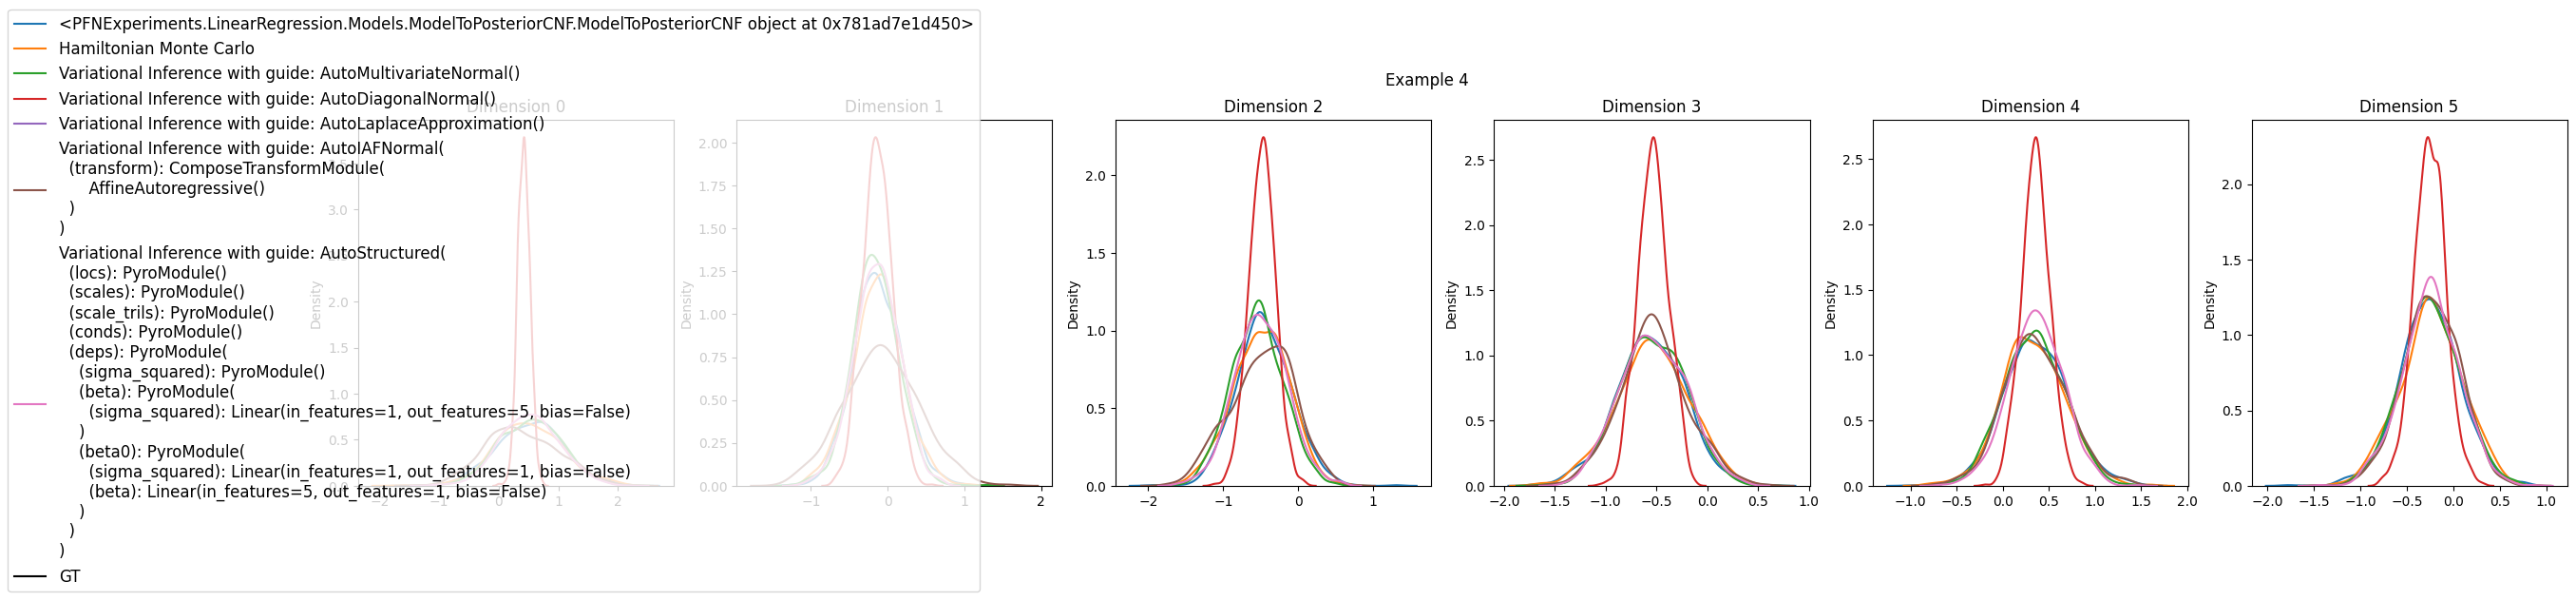

/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 

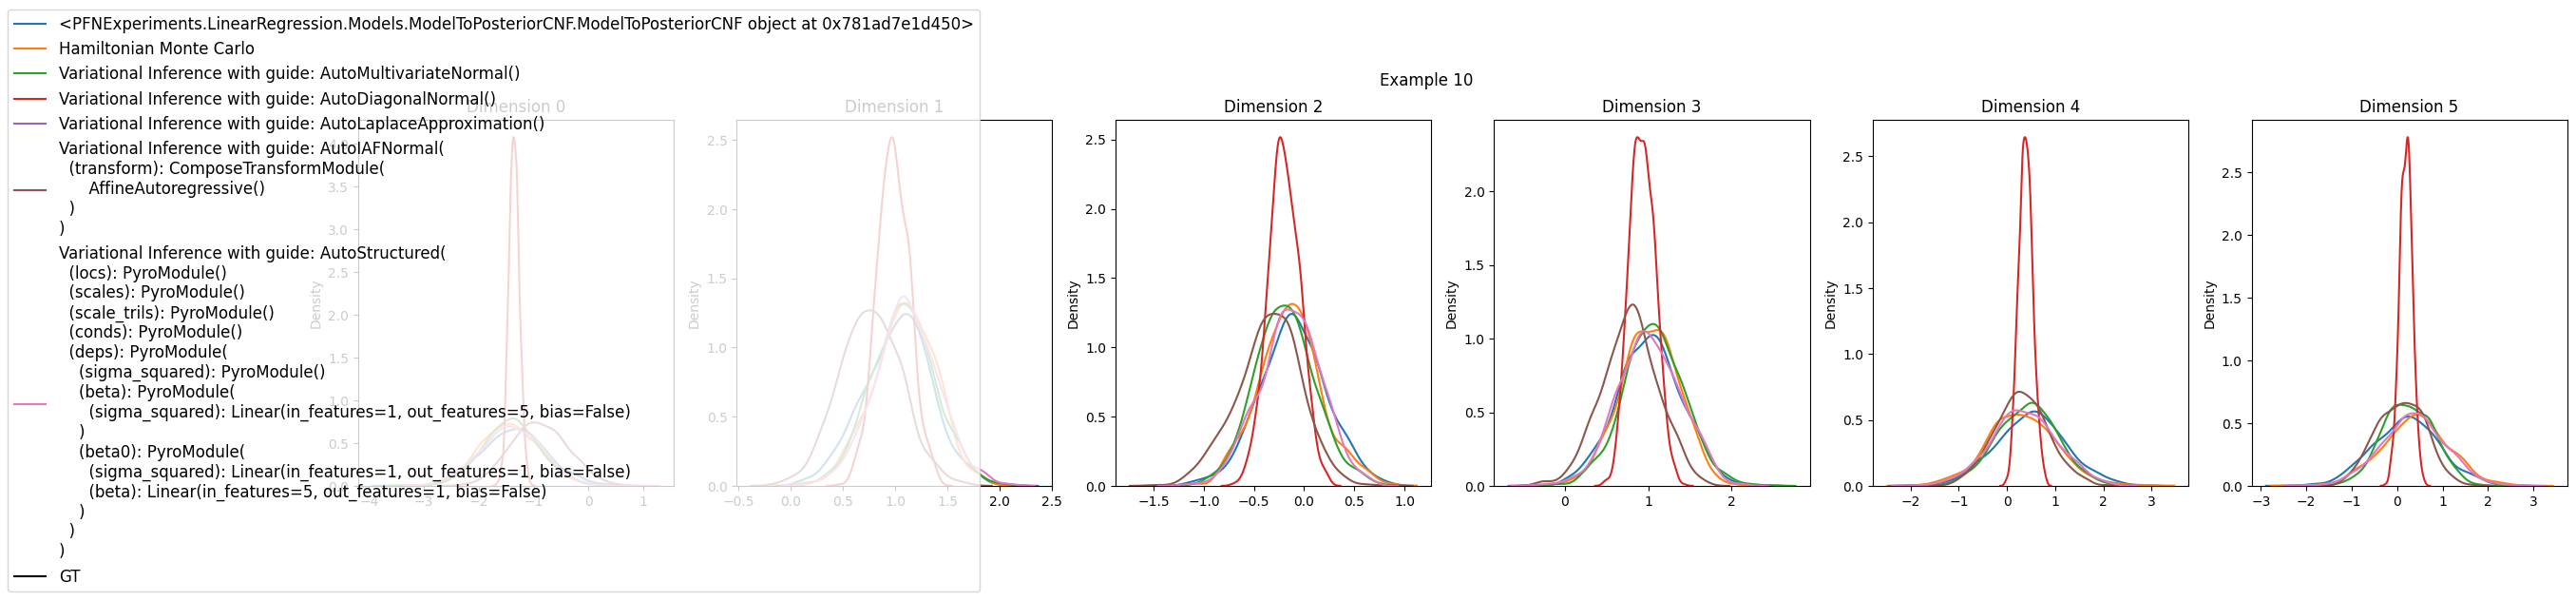

/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 

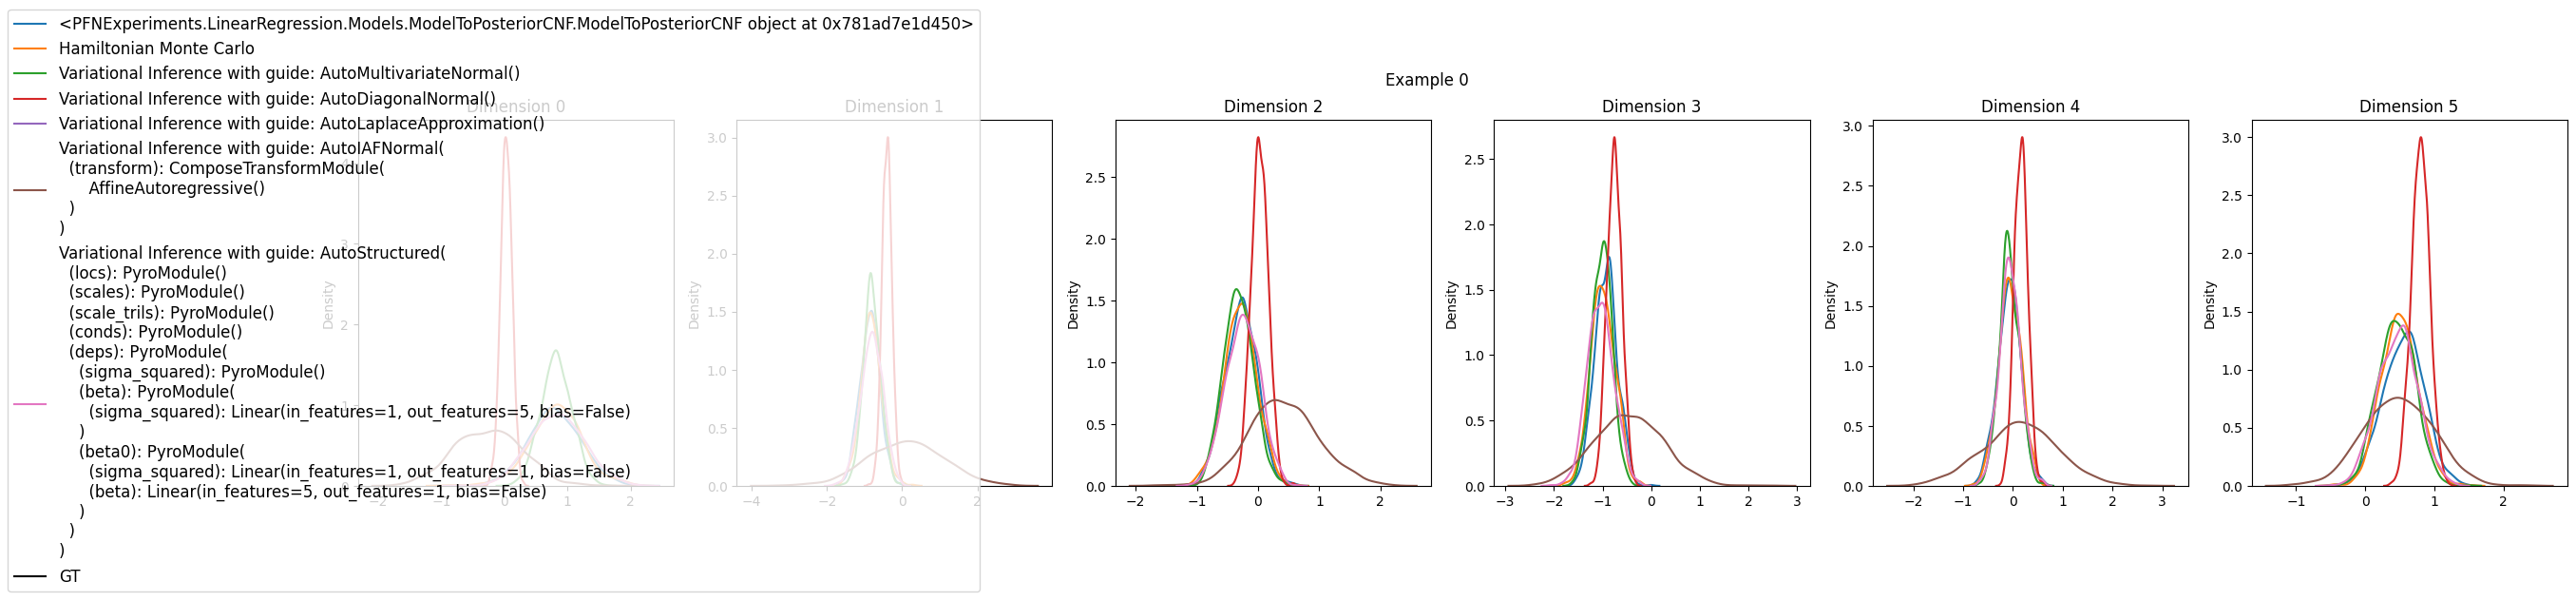

/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 

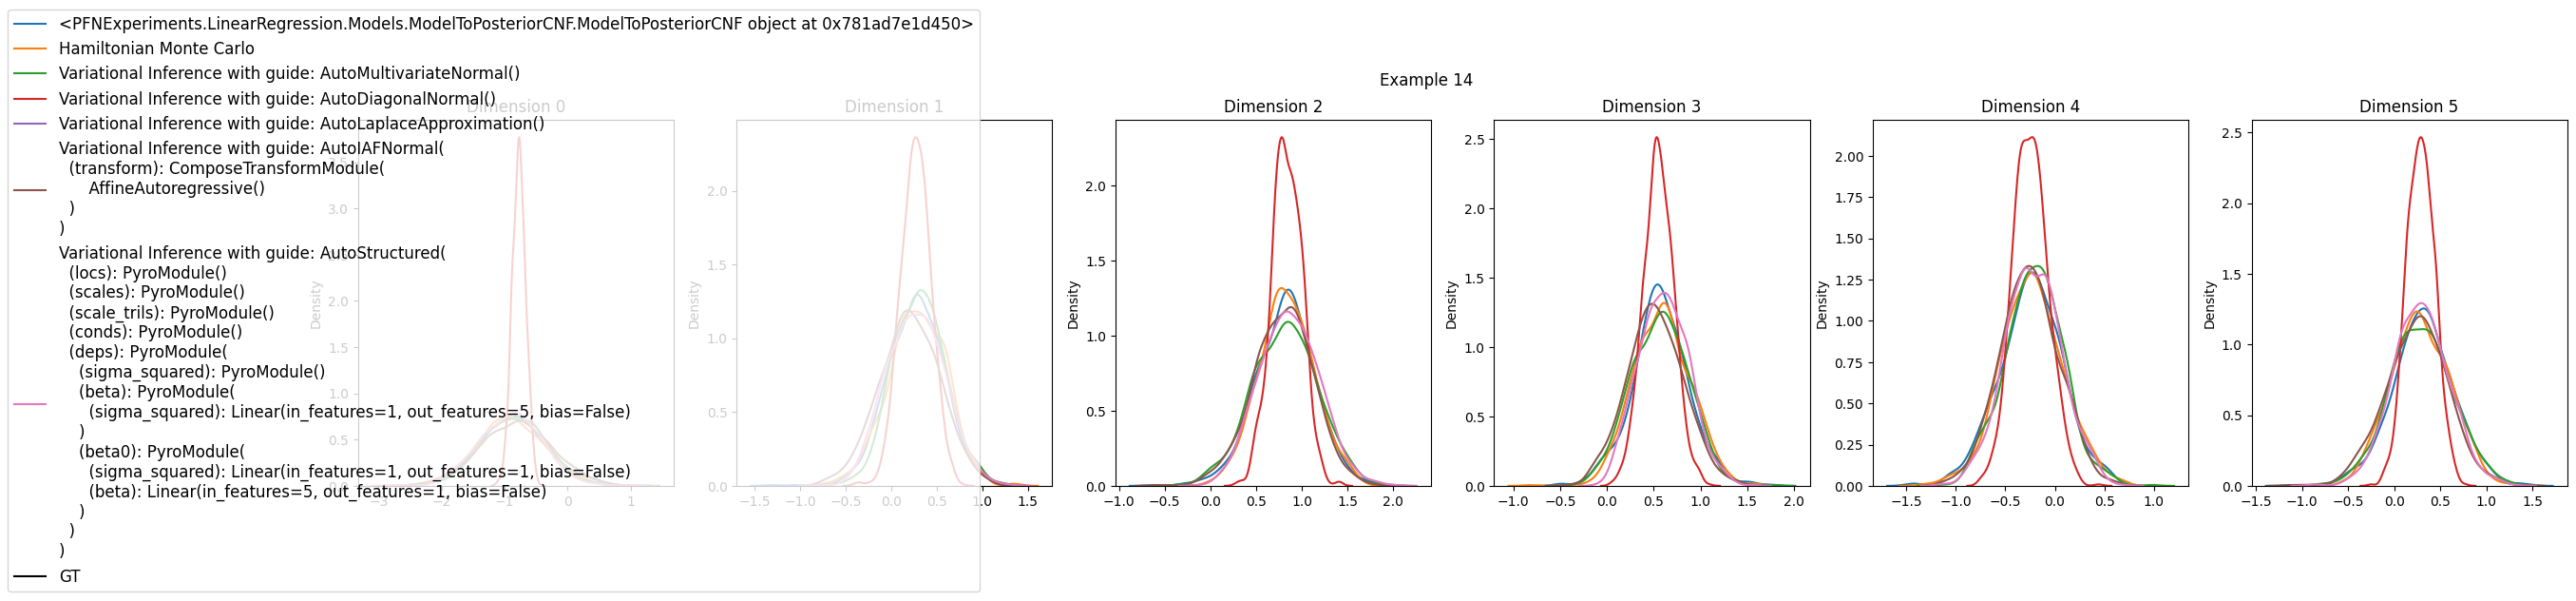

/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 

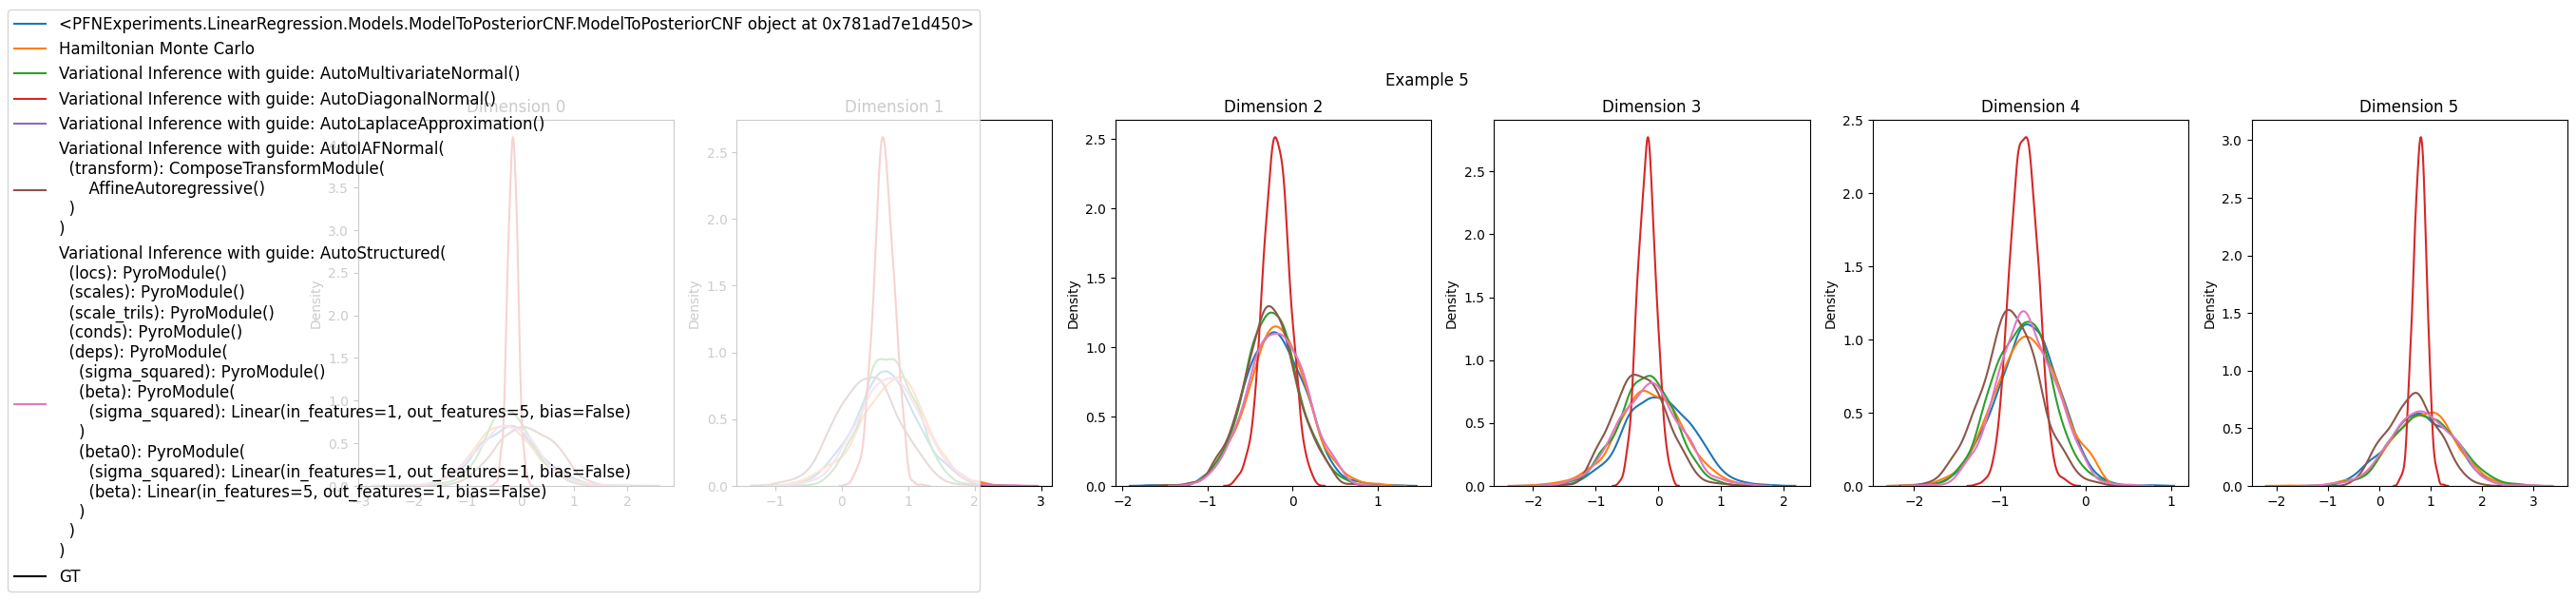

/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 

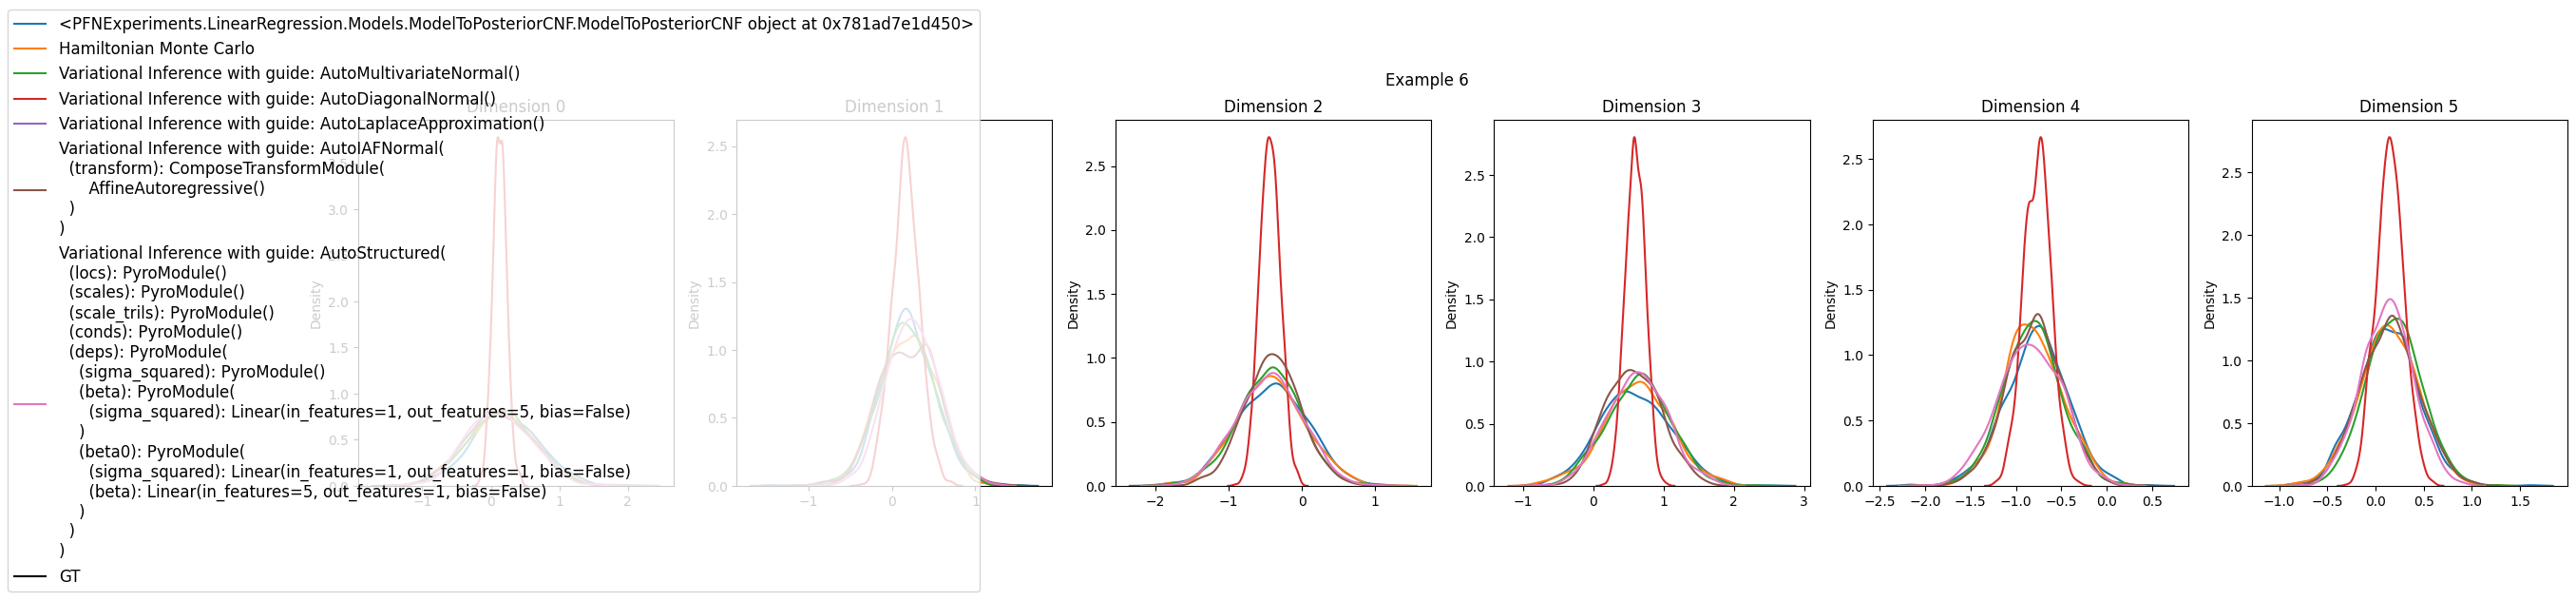

/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 

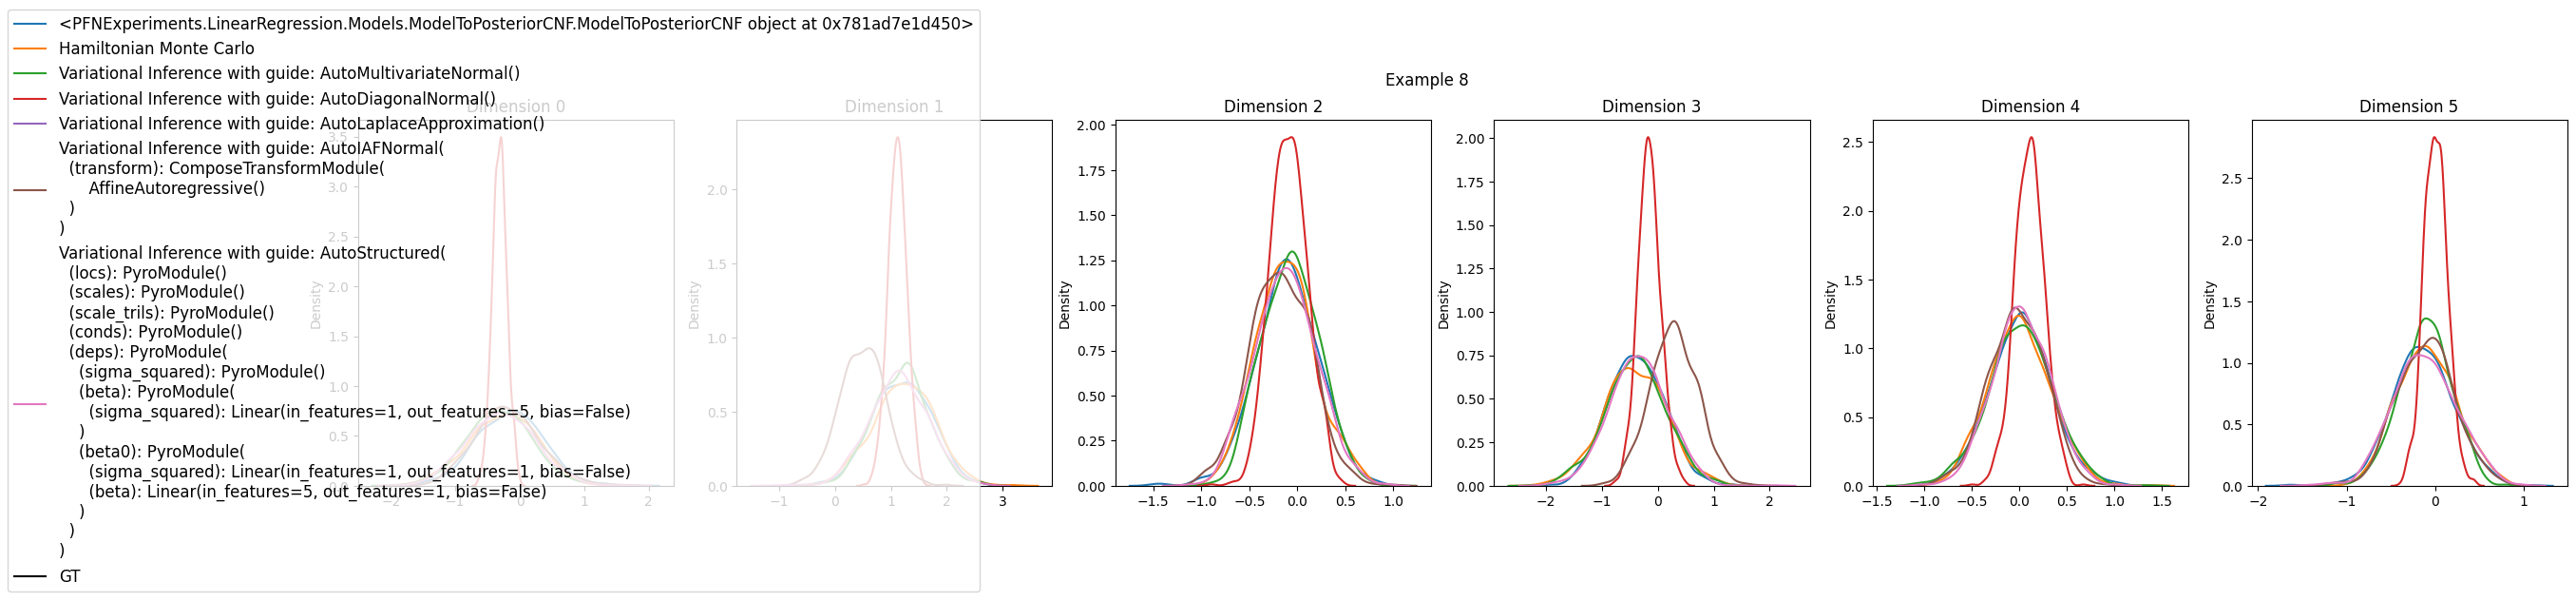

/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 

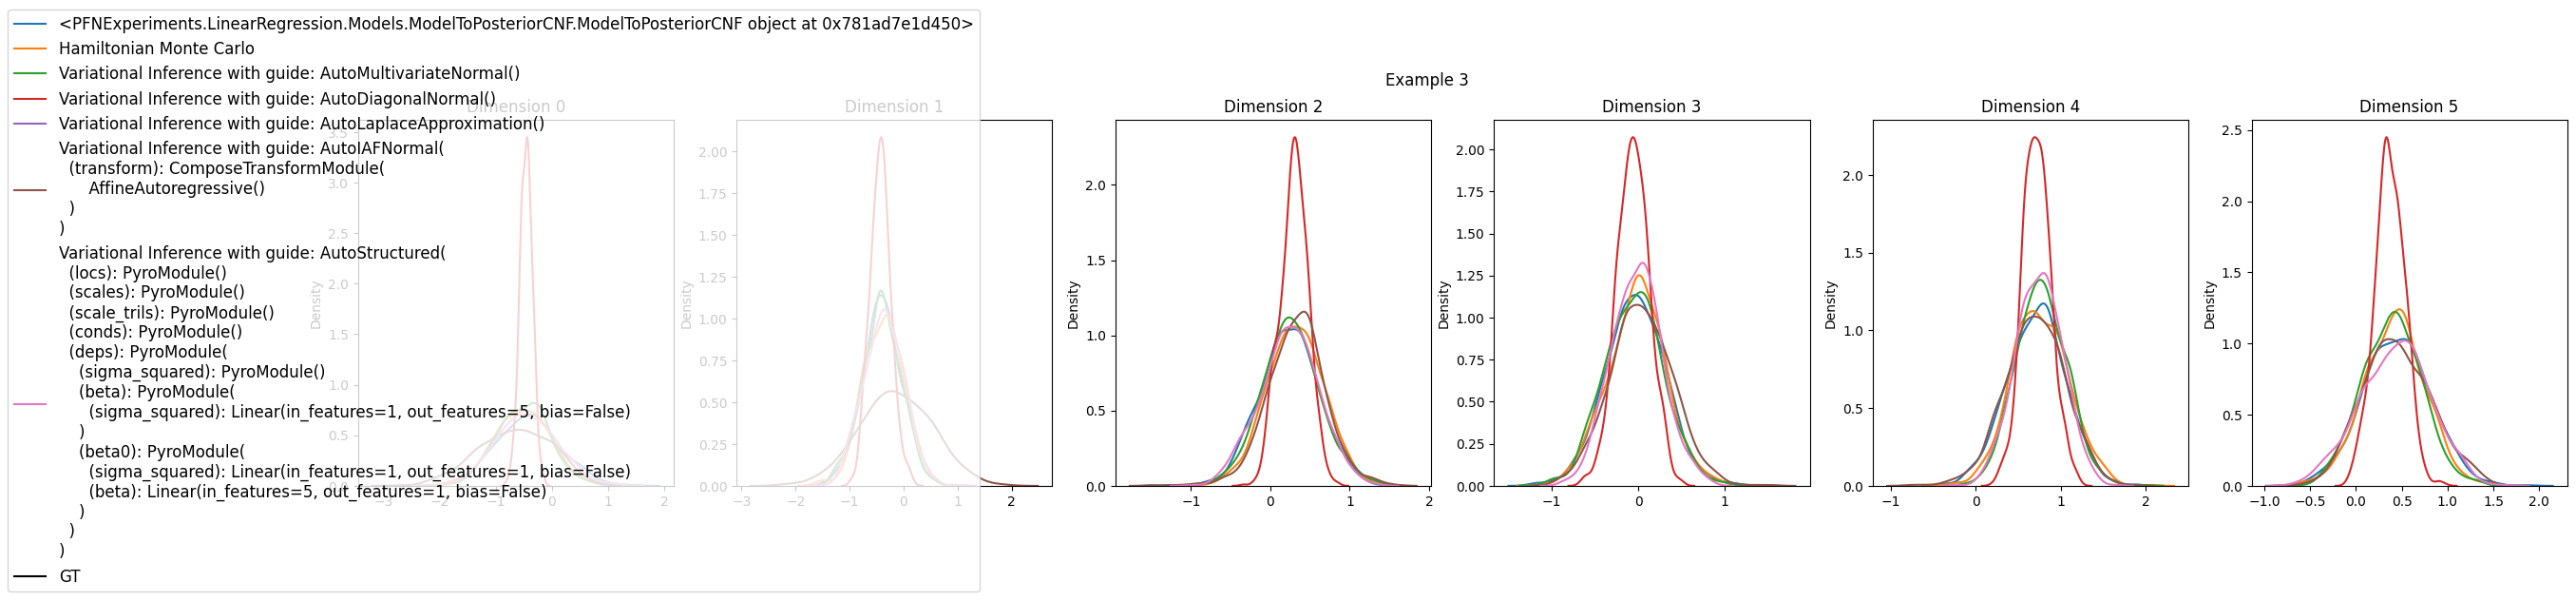

/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 

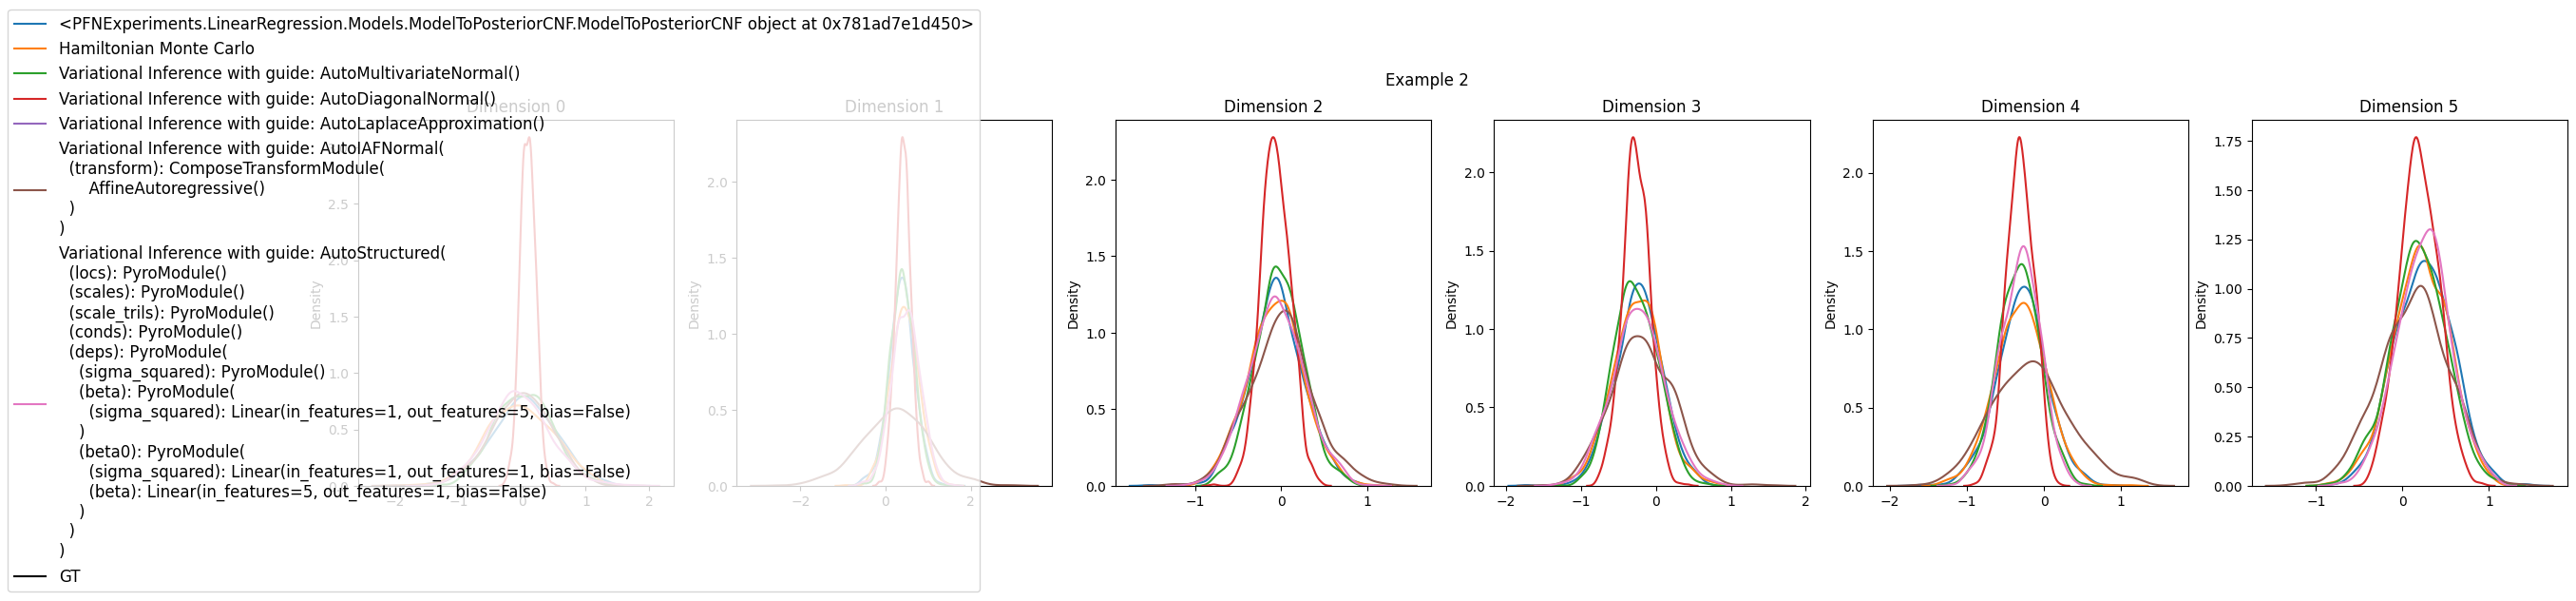

/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 

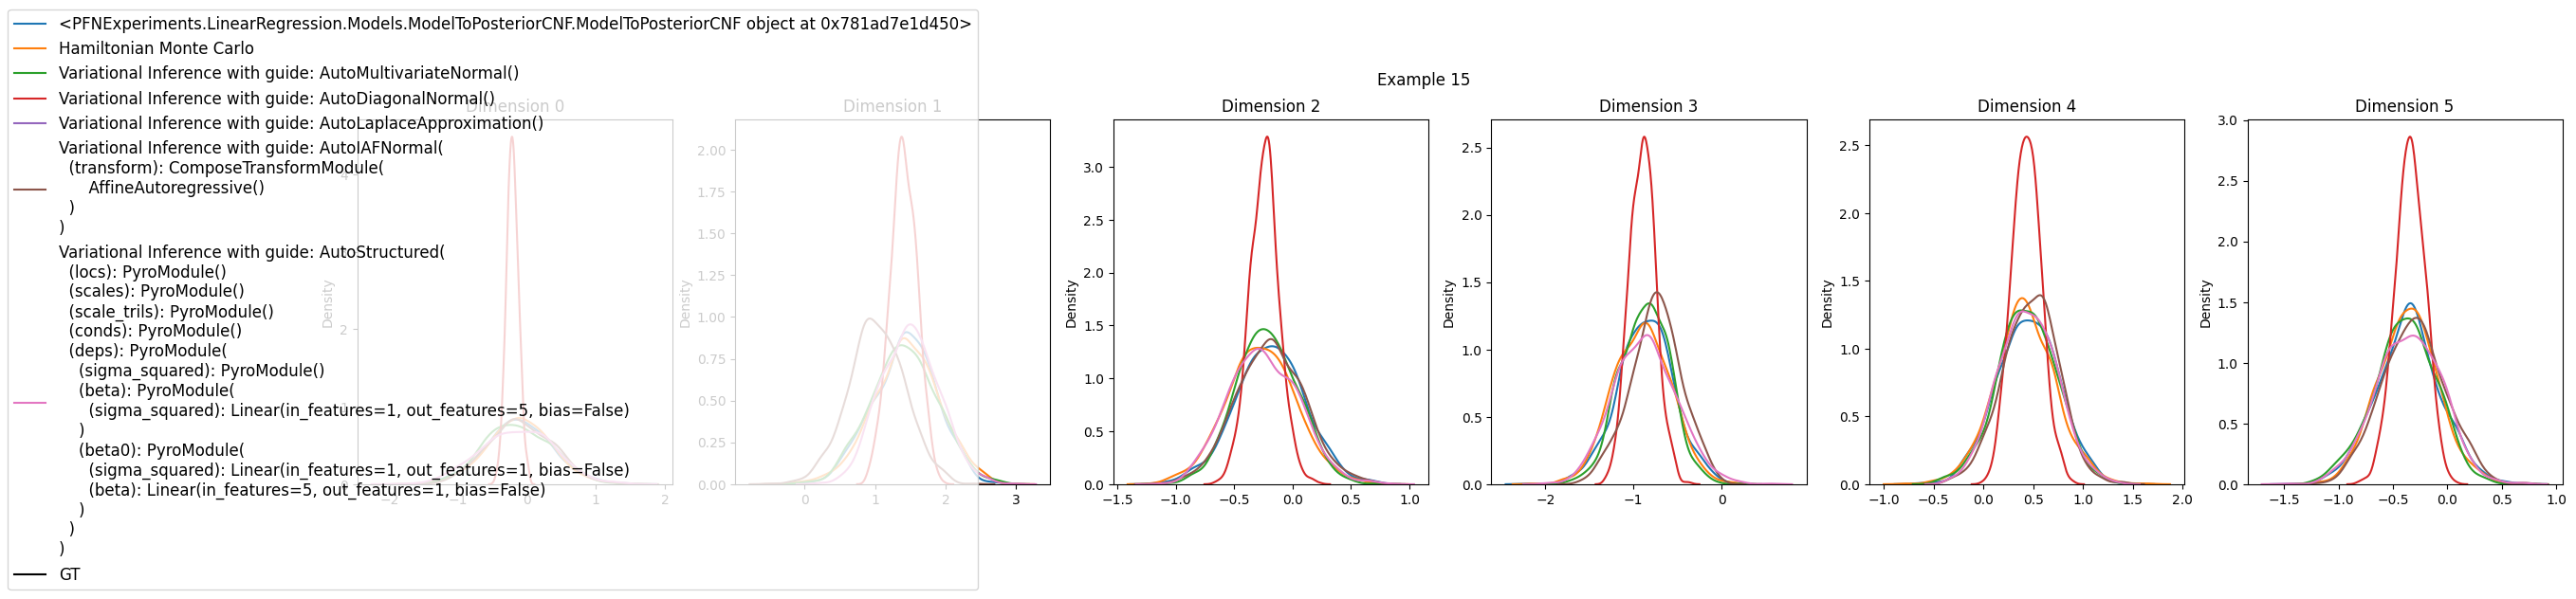

/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 

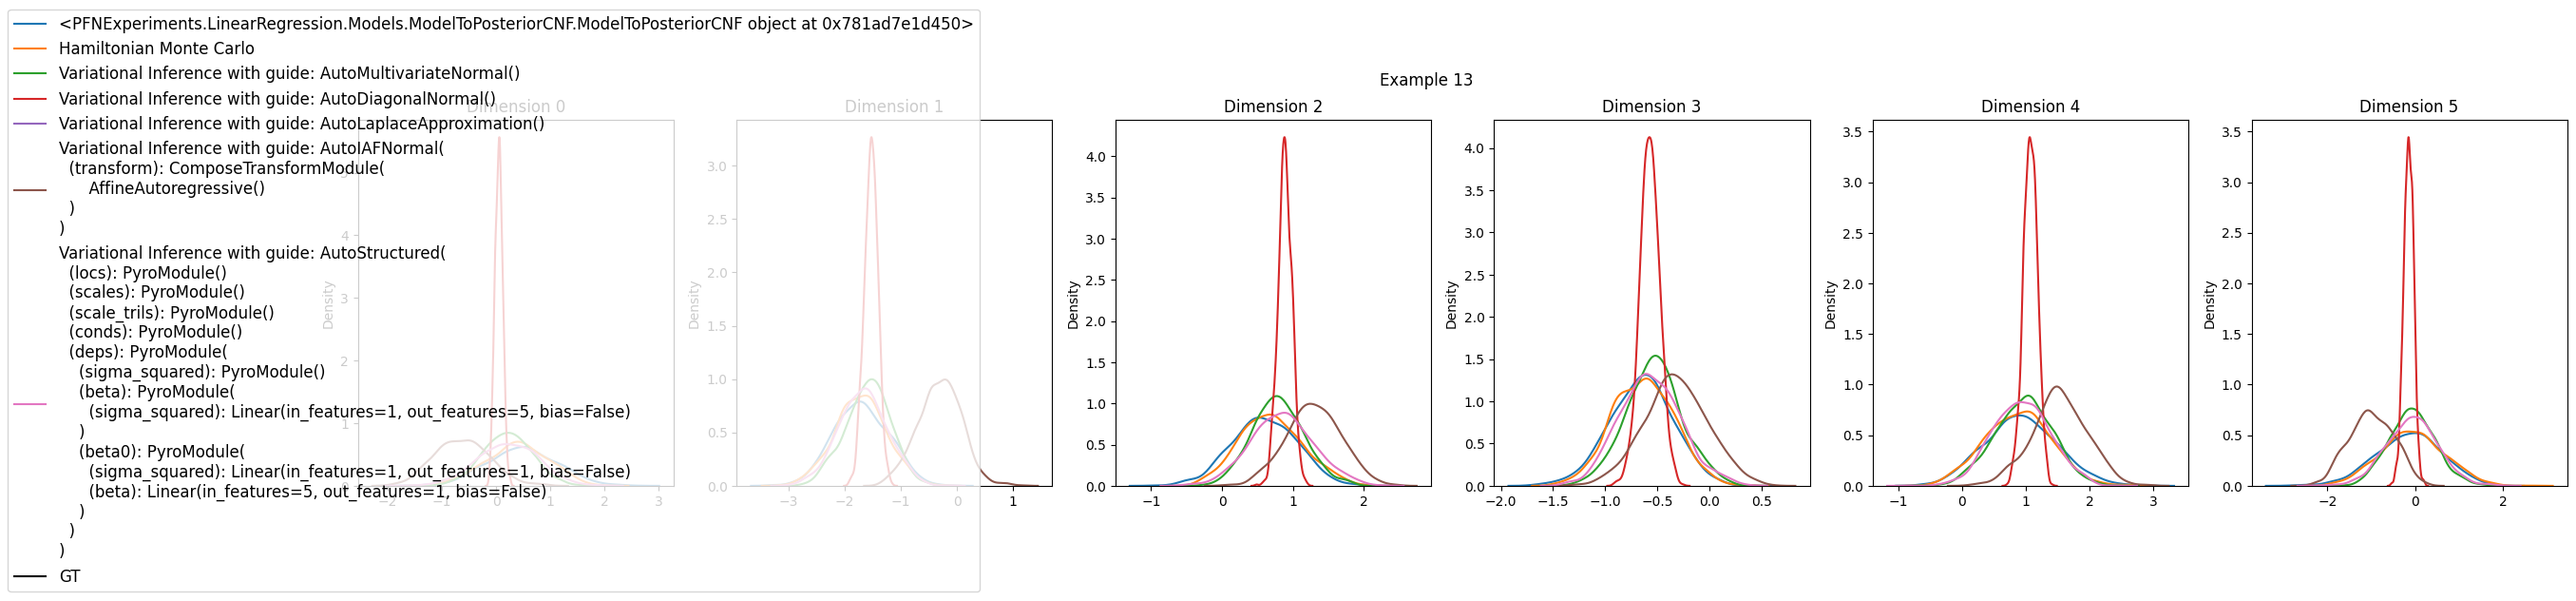

/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 

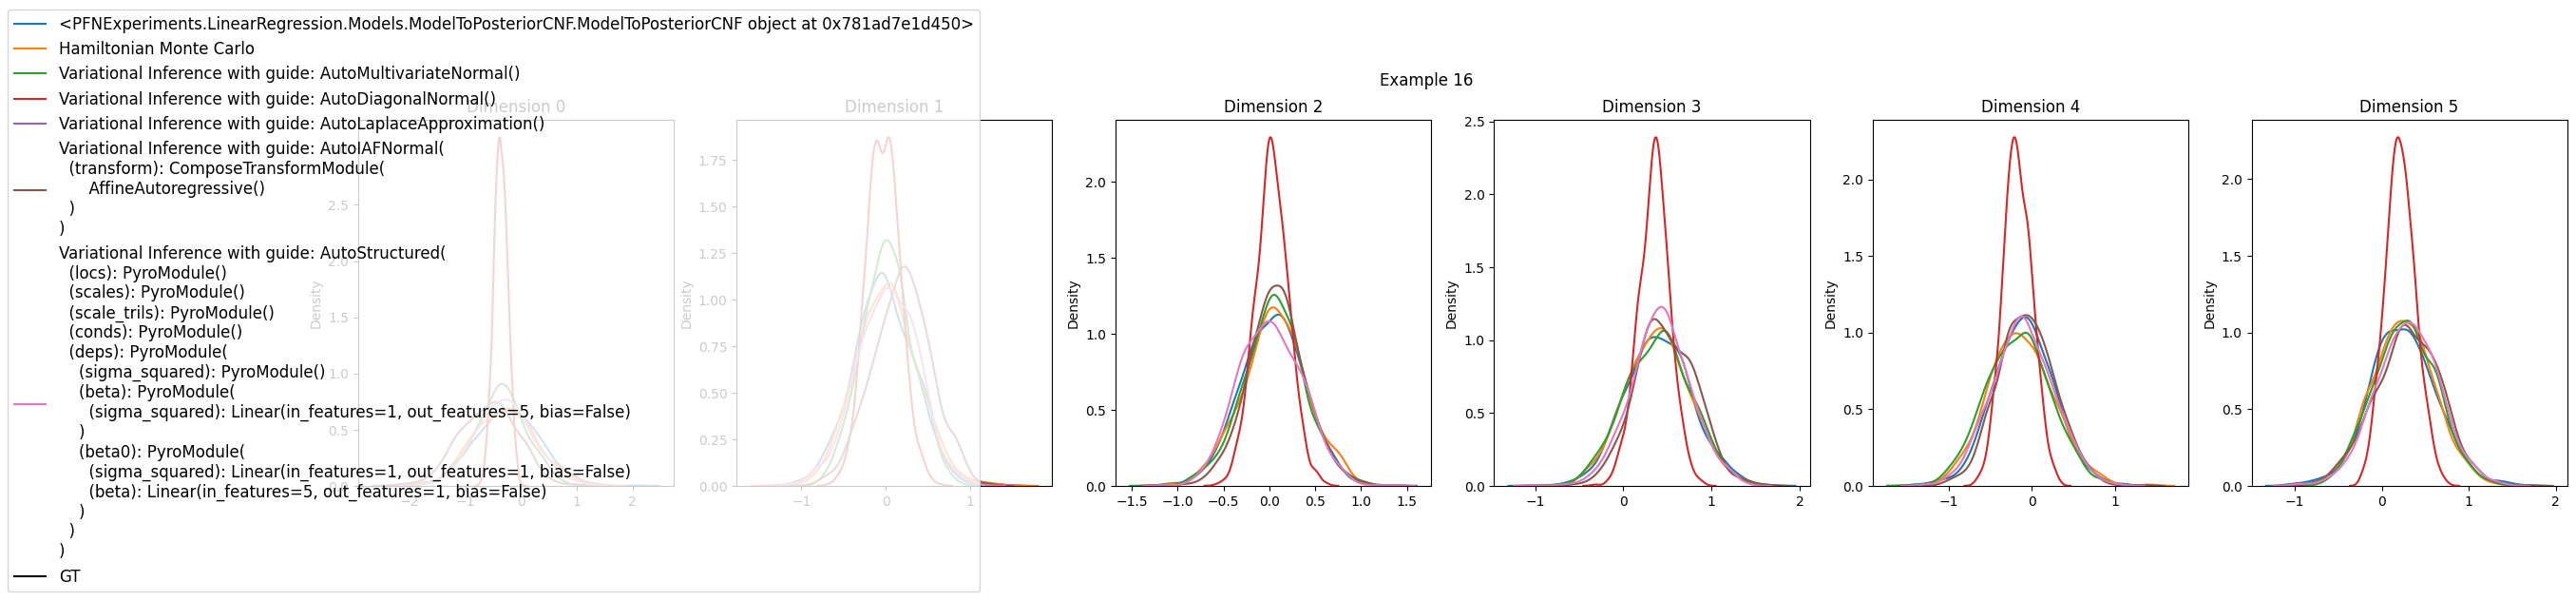

/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 

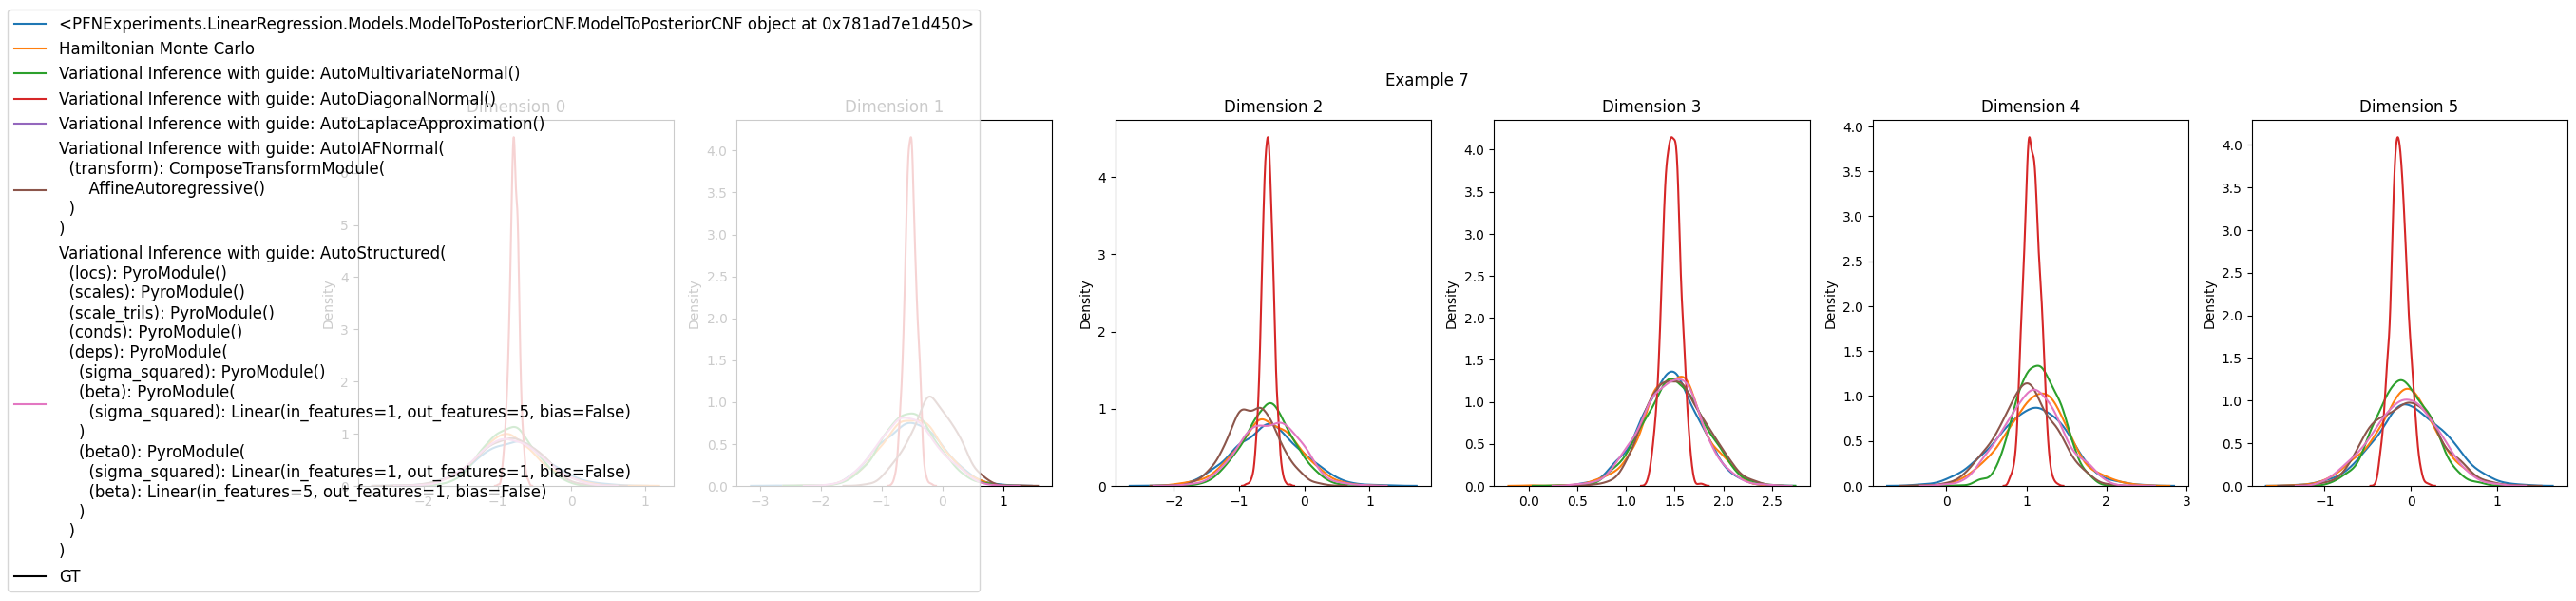

/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 

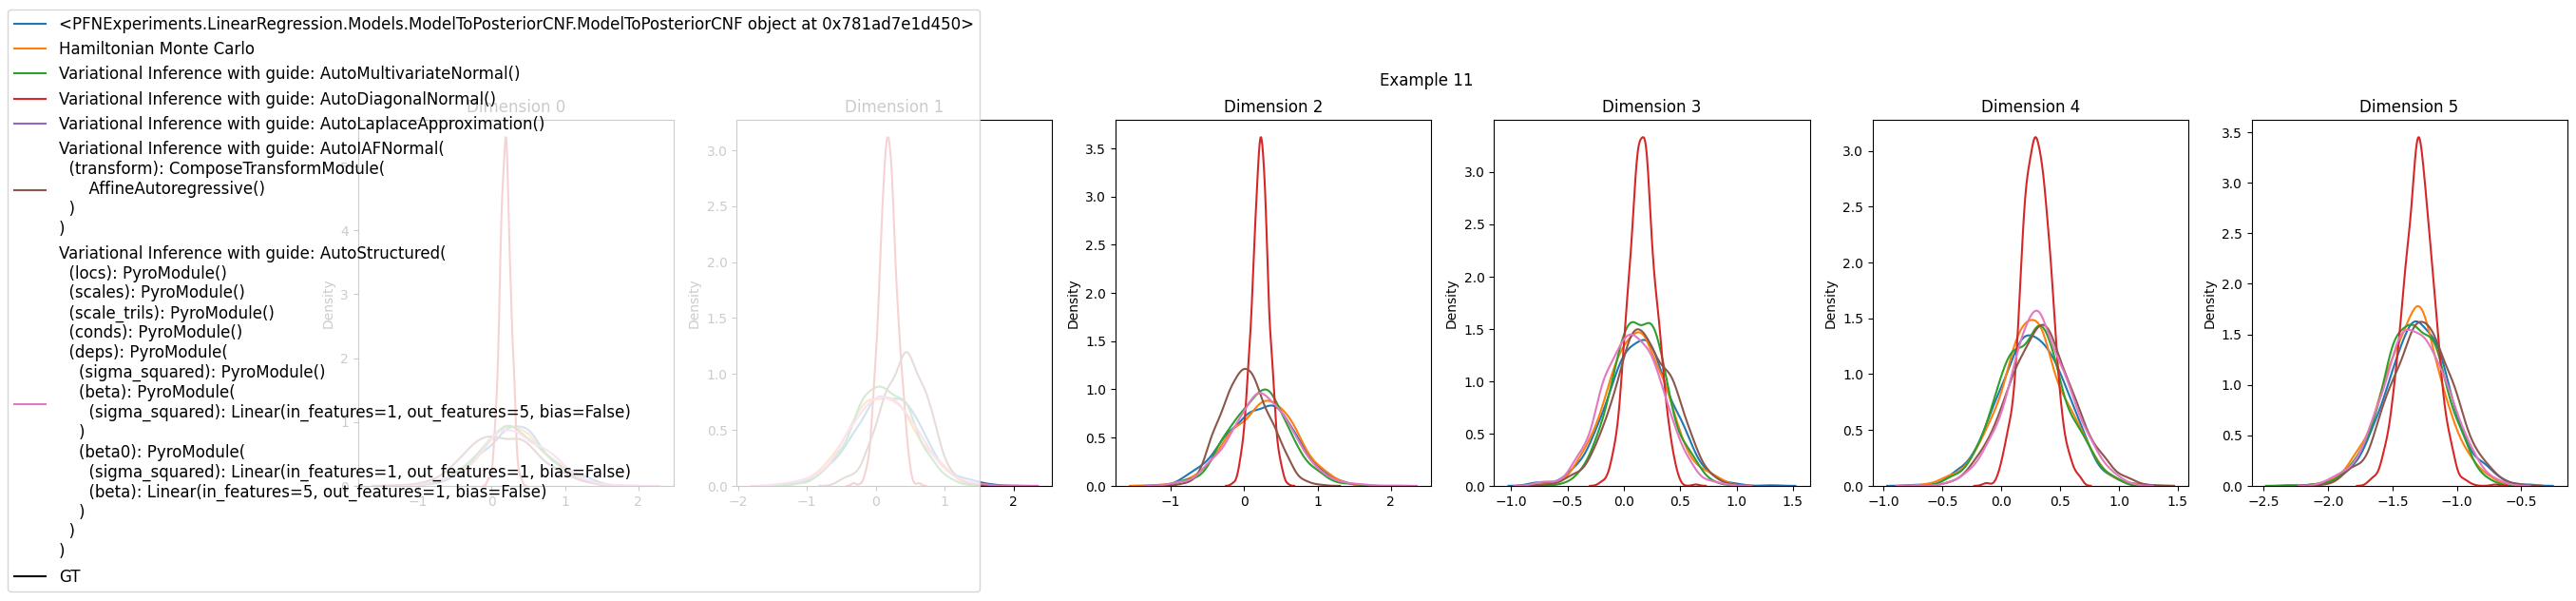

/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 

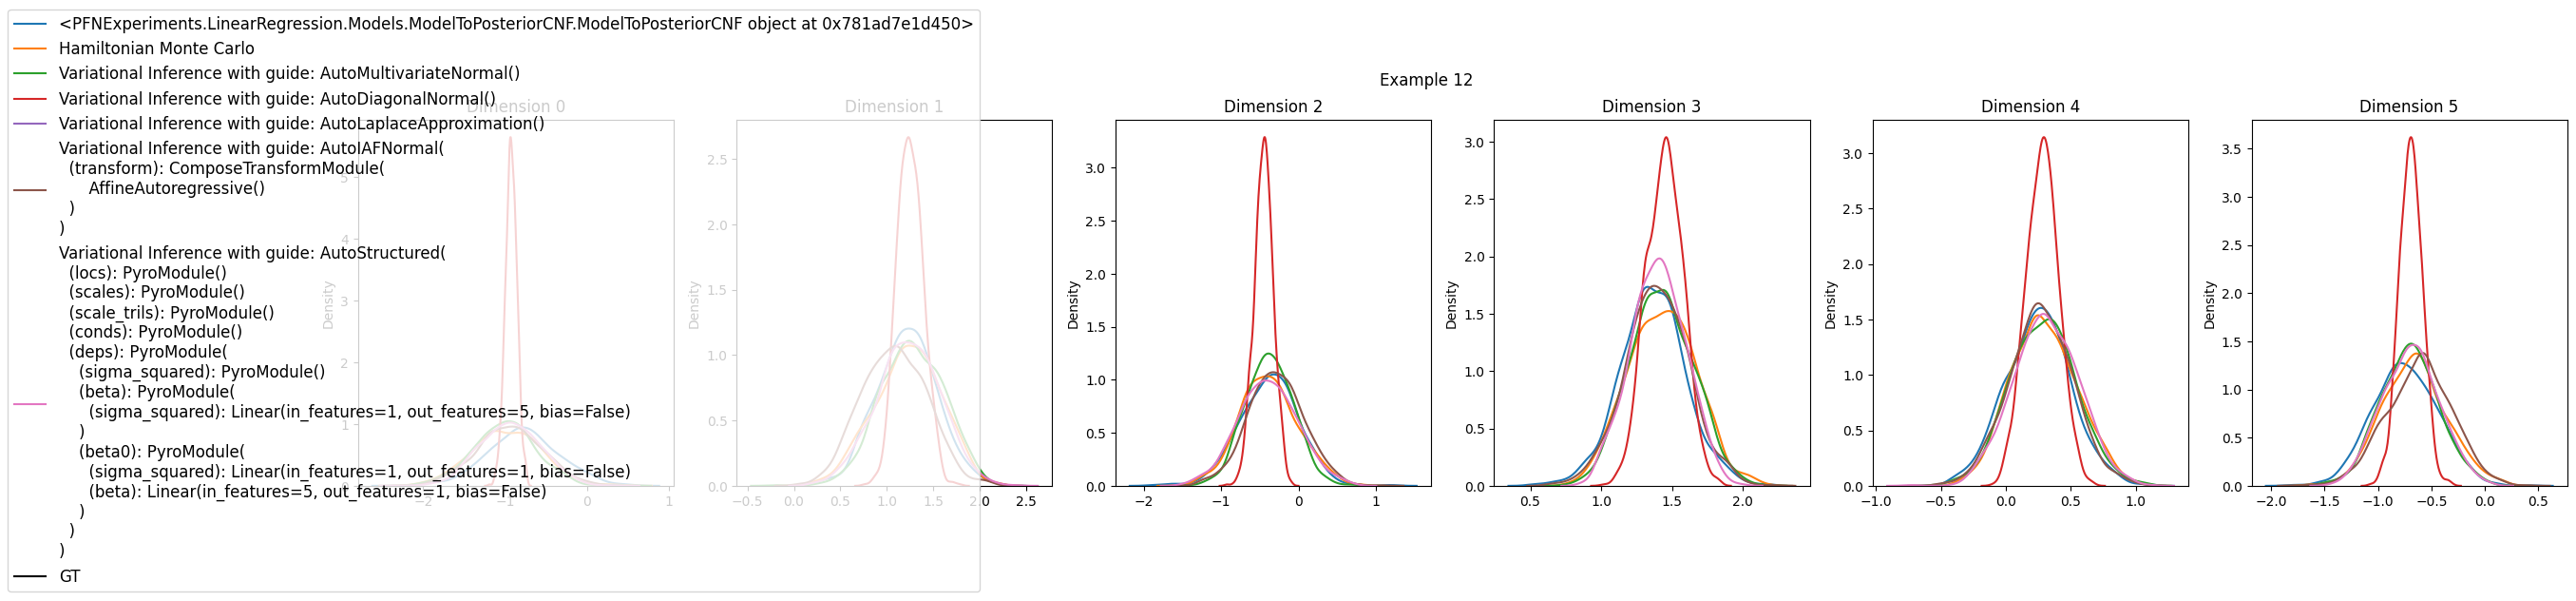

/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 

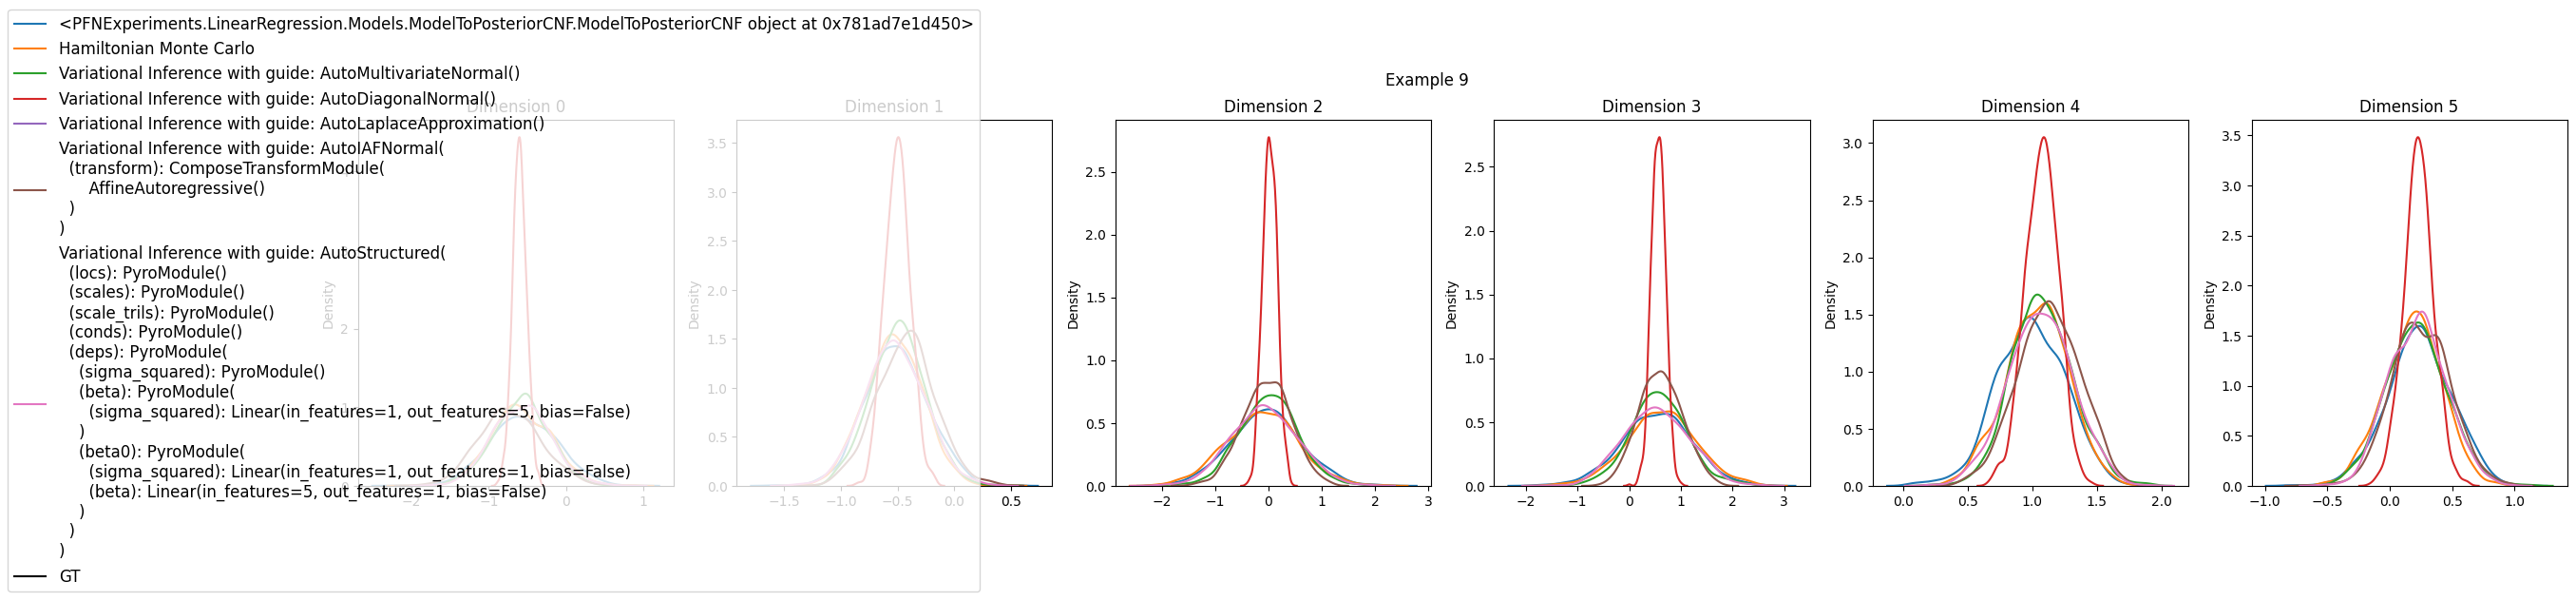

/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples[:, j], ax = ax[j], color = model_color[model])
/content/PFNExperiments/Evaluation/Plot.py:81: UserWarning: Dataset has 

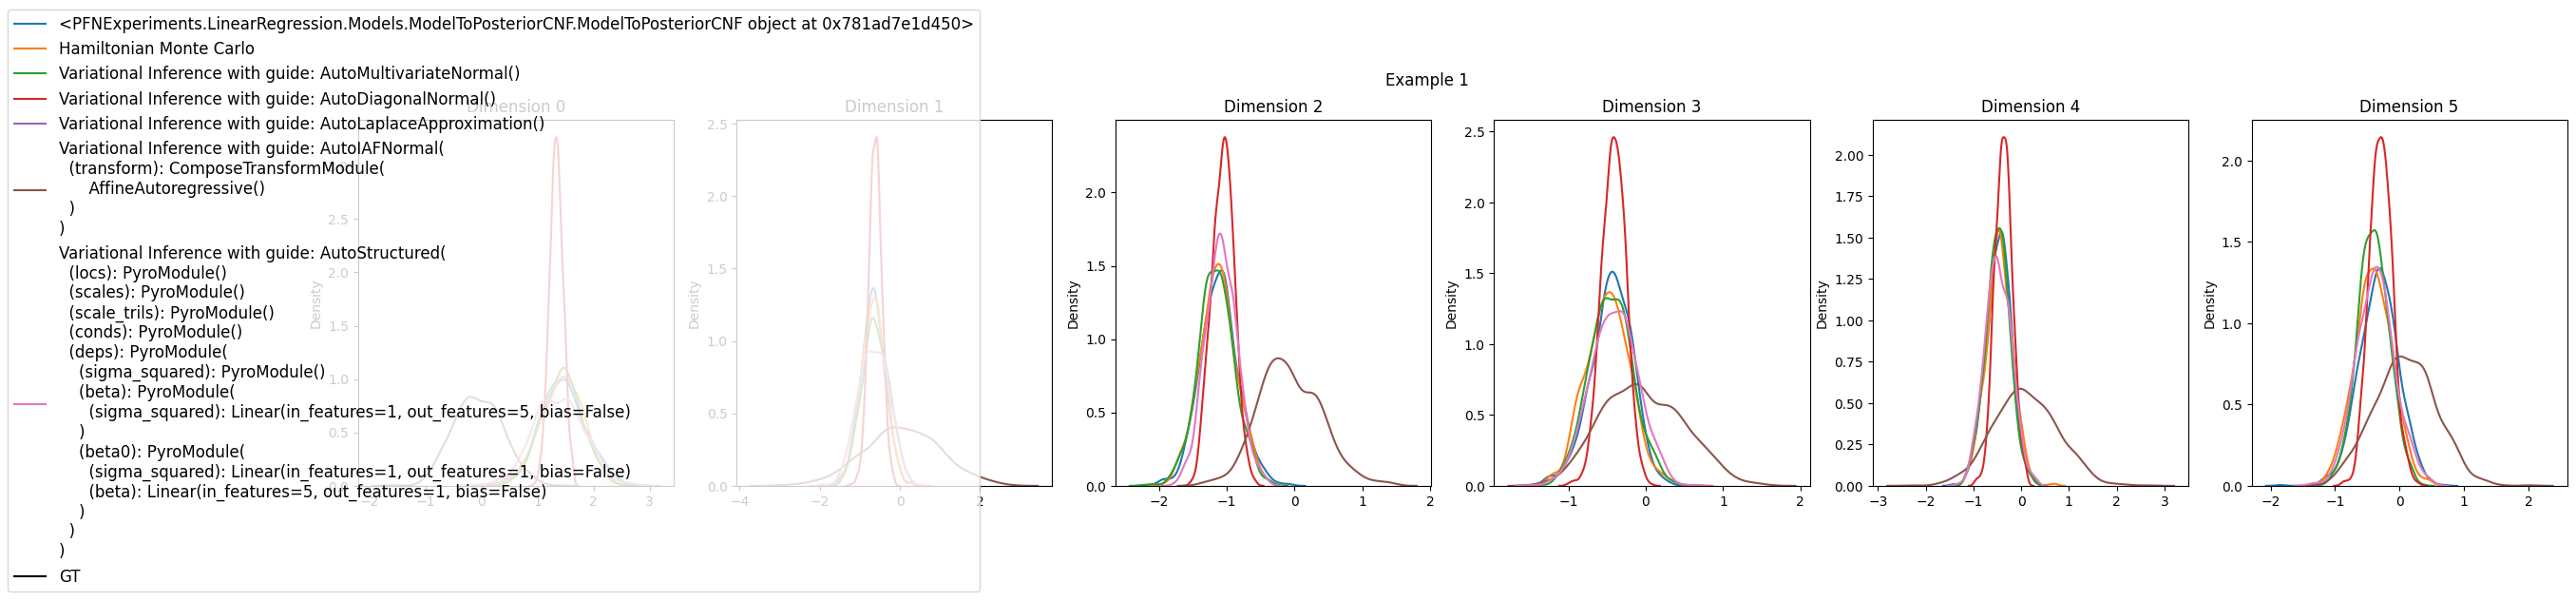

In [ ]:
eval_rw.plot_results(max_number_plots=20)

In [ ]:
ids = [d["id"] for d in datasets]

In [ ]:
len(ids)

17

In [ ]:
 eval_rw.res_raw['posterior_model_vs_comparison_models'].keys()

dict_keys([('<PFNExperiments.LinearRegression.Models.ModelToPosteriorCNF.ModelToPosteriorCNF object at 0x781ad7e1d450>', 'Hamiltonian Monte Carlo'), ('<PFNExperiments.LinearRegression.Models.ModelToPosteriorCNF.ModelToPosteriorCNF object at 0x781ad7e1d450>', 'Variational Inference with guide: AutoMultivariateNormal()'), ('<PFNExperiments.LinearRegression.Models.ModelToPosteriorCNF.ModelToPosteriorCNF object at 0x781ad7e1d450>', 'Variational Inference with guide: AutoDiagonalNormal()'), ('<PFNExperiments.LinearRegression.Models.ModelToPosteriorCNF.ModelToPosteriorCNF object at 0x781ad7e1d450>', 'Variational Inference with guide: AutoLaplaceApproximation()'), ('<PFNExperiments.LinearRegression.Models.ModelToPosteriorCNF.ModelToPosteriorCNF object at 0x781ad7e1d450>', 'Variational Inference with guide: AutoIAFNormal(\n  (transform): ComposeTransformModule(\n      AffineAutoregressive()\n  )\n)'), ('<PFNExperiments.LinearRegression.Models.ModelToPosteriorCNF.ModelToPosteriorCNF object at 0

In [ ]:
res_hmc = eval_rw.res_raw['posterior_model_vs_comparison_models'][('<PFNExperiments.LinearRegression.Models.ModelToPosteriorCNF.ModelToPosteriorCNF object at 0x7d9d73d5ea70>', 'Hamiltonian Monte Carlo')]

KeyError: ('<PFNExperiments.LinearRegression.Models.ModelToPosteriorCNF.ModelToPosteriorCNF object at 0x7d9d73d5ea70>', 'Hamiltonian Monte Carlo')

In [ ]:
len(res_hmc)

In [ ]:
import pandas as pd

In [ ]:
res_hmc_df = pd.DataFrame(res_hmc)

In [ ]:
res_hmc_df["id"] = ids

In [ ]:
res_hmc_df

In [ ]:
d = datasets[0]

print(d)

n_diff_y_vals = len(torch.unique(d["y"]))
n_diff_y_vals_x = [len(torch.unique(d["x"][:, i])) for i in range(P)]

print(f"n_diff_y_vals: {n_diff_y_vals}")
print(f"n_diff_x_vals: {n_diff_y_vals_x}")

print(f"y_var: {torch.var(d['y'])}")